# GPU

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "GPU(s) física(s),", len(logical_gpus), "GPU(s) lógica(s)")
        print("Funciona")
    except RuntimeError as e:
        print(e)
else:
    print("Error")

1 GPU(s) física(s), 1 GPU(s) lógica(s)
Funciona


# Imports

In [2]:
import os 
import requests
from zipfile import ZipFile 
import shutil #para copiar las imagenes de FER2013 y CK a data
import pandas as pd #para crear dataframe
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split #dividir la data de train en train ,test y val
from collections import Counter #para contar la cantidad de labels de cada generador
from keras.preprocessing.image import ImageDataGenerator #para crear el generador e iterador por dataframe o directory(), además pre-processing
import numpy as np 
import matplotlib.pyplot as plt #Gráficar
from keras.preprocessing import image 
from keras.callbacks import ModelCheckpoint #para crear un punto de control y guardar cada acc en cada epochs que mejore
from datetime import datetime #para tensorboard
from tensorflow.keras.callbacks import TensorBoard #para tensorboard
from keras.applications import InceptionResNetV2 
from keras.models import Sequential, Model 
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D 
import PIL

from keras.applications import EfficientNetB0
from keras.layers import BatchNormalization, Dropout, Dense, Conv2D, MaxPooling2D, GlobalMaxPooling2D,GlobalAveragePooling2D, Input
from keras.models import Model
from keras.regularizers import L2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

from keras.applications import InceptionV3
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D, Flatten,GaussianNoise, BatchNormalization, Conv2D, Input
from tensorflow.keras.optimizers import Adam,SGD
from keras.regularizers import L2
from keras.callbacks import EarlyStopping, LearningRateScheduler
import math
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from PIL import Image
from kerastuner.tuners import RandomSearch
from tqdm import tqdm


C:\Users\bryan\AppData\Local\Temp\ipykernel_9524\4200436790.py:41: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [3]:
import random, os
import numpy as np
import tensorflow as tf

def set_seed(seed=42):
  np.random.seed(seed) 
  tf.random.set_seed(seed) 
  random.seed(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = "1"
  os.environ['TF_CUDNN_DETERMINISM'] = "1"
  os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

# Data analysis

In [4]:
train_dir = 'fer2013/train'
test_dir = 'fer2013/test'

In [15]:
def count_images_byClass(directory):
    classes = sorted(os.listdir(directory))
    num_images = []
    for clase in classes:
        class_dir = os.path.join(directory, clase)
        num_images.append(len(os.listdir(class_dir)))
    return classes, num_images

train_classes, train_num_images = count_images_byClass(train_dir)
test_classes, test_num_images = count_images_byClass(test_dir)


print("Names of classes in train set: ", train_classes)
print("Numbers by classes in train set", train_num_images)

print("Names of classes in test set: ", test_classes)
print("Numbers by classes in test set", test_num_images)

Names of classes in train set:  ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Numbers by classes in train set [3995, 436, 4097, 7215, 4965, 4830, 3171]
Names of classes in test set:  ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Numbers by classes in test set [958, 111, 1024, 1774, 1233, 1247, 831]


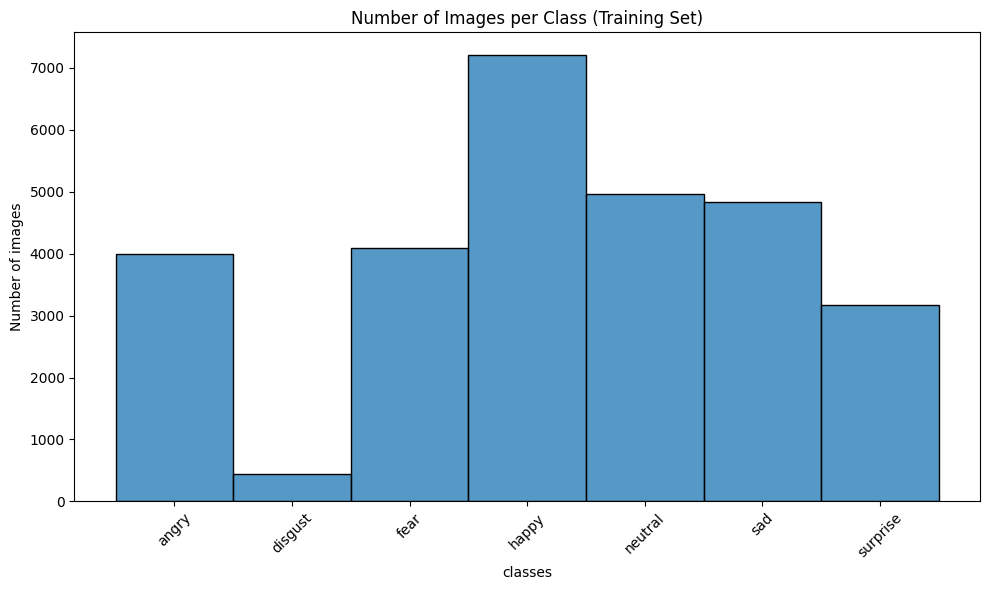

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(x=train_classes, weights=train_num_images, bins=len(train_classes), kde=False)
plt.xticks(rotation=45)
plt.xlabel('classes')
plt.ylabel('Number of images')
plt.title('Number of Images per Class (Training Set)')
plt.tight_layout()
plt.show()

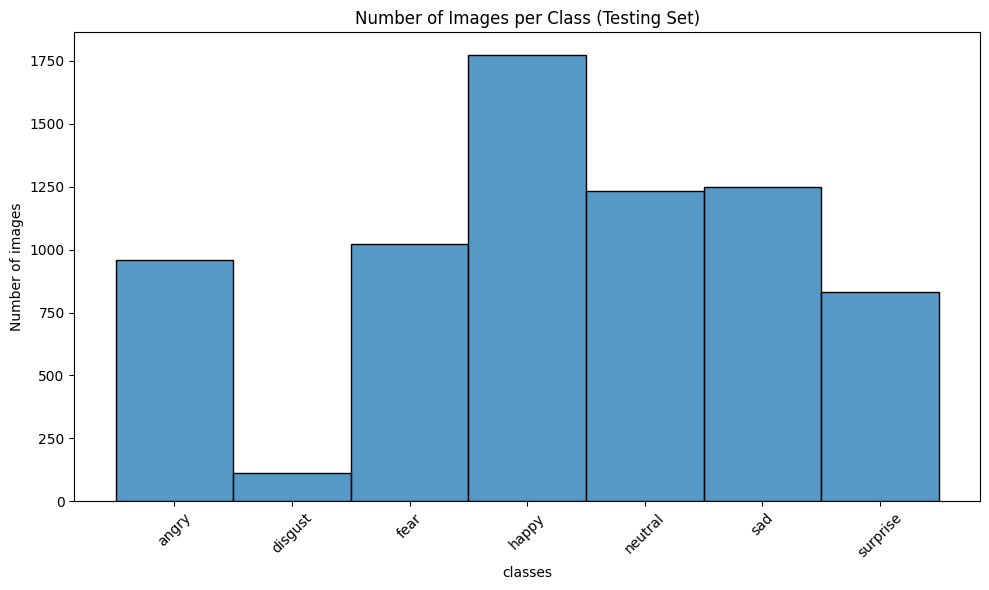

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(x=test_classes, weights=test_num_images, bins=len(test_classes), kde=False)
plt.xticks(rotation=45)
plt.xlabel('classes')
plt.ylabel('Number of images')
plt.title('Number of Images per Class (Testing Set)')
plt.tight_layout()
plt.show()

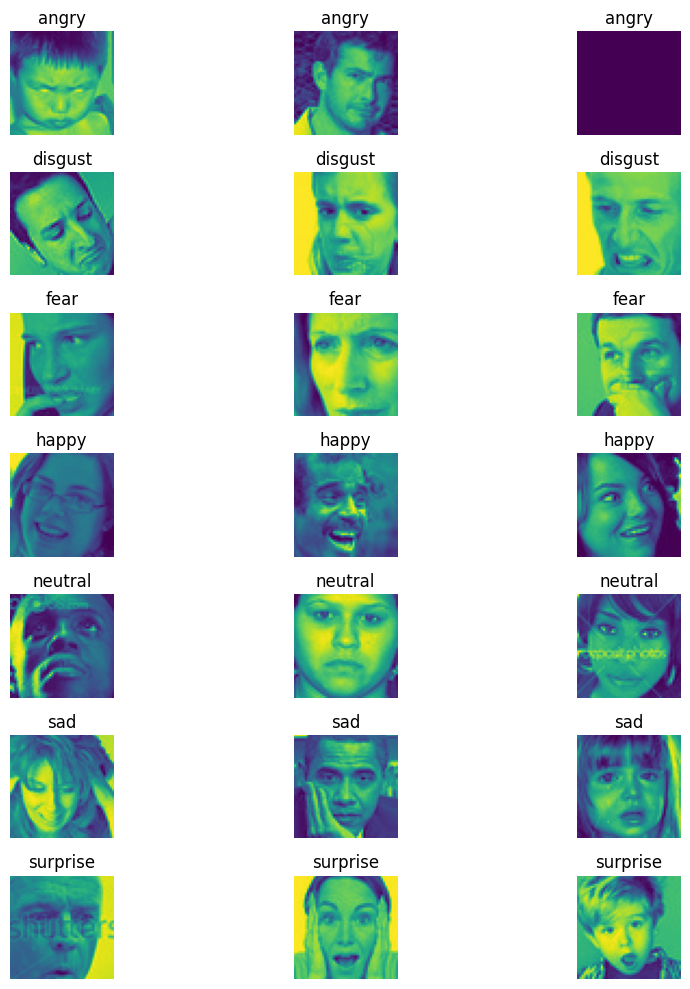

In [18]:
def ShowExamples(directory, classes, num_examples=3):
    plt.figure(figsize=(10, 10))
    for i, clase in enumerate(classes):
        class_dir = os.path.join(directory, clase)
        image_files = os.listdir(class_dir)[:num_examples]
        for j, image_file in enumerate(image_files):
            image_path = os.path.join(class_dir, image_file)
            image = Image.open(image_path)
            plt.subplot(len(classes), num_examples, i * num_examples + j + 1)
            plt.imshow(image)
            plt.title(clase)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

ShowExamples(train_dir, train_classes, num_examples=3)


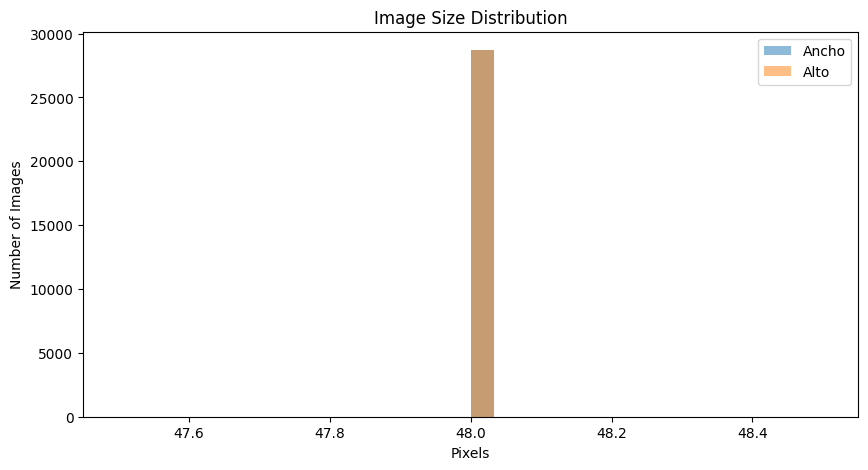

In [30]:
def image_size_distribution(directory):
    image_sizes = []
    for clase in os.listdir(directory):
        class_dir = os.path.join(directory, clase)
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            image = Image.open(image_path)
            width, height = image.size
            image_sizes.append((width, height))
    image_sizes = np.array(image_sizes)
    
    plt.figure(figsize=(10, 5))
    plt.hist(image_sizes[:, 0], bins=30, alpha=0.5, label='Ancho')
    plt.hist(image_sizes[:, 1], bins=30, alpha=0.5, label='Alto')
    plt.title('Image Size Distribution')
    plt.xlabel('Pixels')
    plt.ylabel('Number of Images')
    plt.legend()
    plt.show()

image_size_distribution(train_dir)


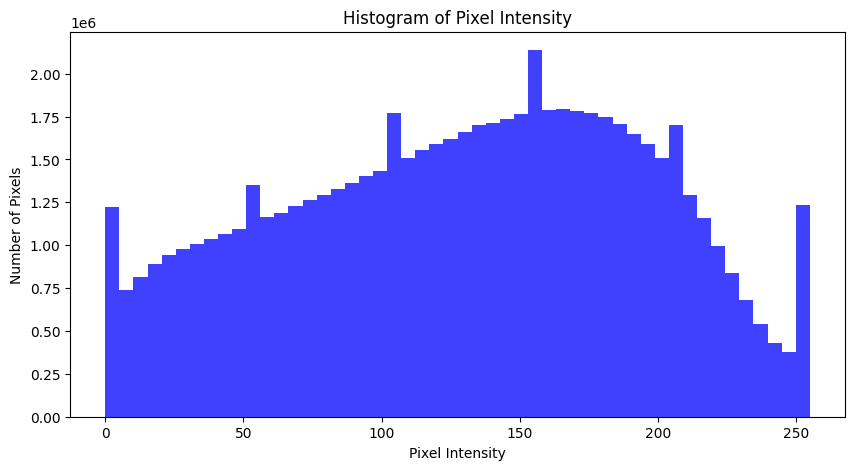

In [31]:
def intensity_histogram(directory):
    pixel_intensities = []
    for clase in os.listdir(directory):
        class_dir = os.path.join(directory, clase)
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            image = Image.open(image_path).convert('L')  
            intensities = np.array(image).flatten()
            pixel_intensities.extend(intensities)
    pixel_intensities = np.array(pixel_intensities)
    
    plt.figure(figsize=(10, 5))
    plt.hist(pixel_intensities, bins=50, alpha=0.75, color='b')
    plt.title('Histogram of Pixel Intensity')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Number of Pixels')
    plt.show()

intensity_histogram(train_dir)


In [37]:
data_dir = 'fer2013/train' #se define la ubicación de la carpeta de los datos
filepath = [] #se define la lista donde van a estar todas las ubicaciones de cada imagen
labels = [] #se define la lista donde va a estar todos los labels
classes = os.listdir(data_dir) #lista las clases

for classfolder in classes: #por cada clase
    folderclass = os.path.join(data_dir, classfolder) #obtiene la ruta
    file_list = os.listdir(folderclass) #ingresa y los lista
    for files in file_list: #por cada archivo dentro de las clases
      pathfile = os.path.join(folderclass,files) #obtiene la ruta
      filepath.append(pathfile) #ingresa el path del file en filepath
      labels.append(classfolder) #ingresa el labels del file en labels



datos = pd.DataFrame({'filepath': filepath, 'labels':labels})
#Se crea un dataframe que tenga una columna llamada filepath, donde va a tener la lista de las ubicaciones de las imagenes
#Se crea una columna llamada labels que va a tener la lista de los labels de cada file (filepath)

In [38]:
datos.describe()

,filepath,labels
count,28709,28709
unique,28709,7
top,fer2013/train\angry\Training_10118481.jpg,happy
freq,1,7215


In [39]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  28709 non-null  object
 1   labels    28709 non-null  object
dtypes: object(2)
memory usage: 448.7+ KB


# Data augmentation and definition of importance by classes (balancing) in the train set

In [5]:
img_shape = 48
batch_size = 64

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'fer2013/train'
test_dir = 'fer2013/test'

train_datagen = ImageDataGenerator(
    rescale=1/255,                
    rotation_range=10,            
    zoom_range=0.2,               
    width_shift_range=0.1,        
    height_shift_range=0.1,           
    horizontal_flip=True,         
    fill_mode='nearest',          
    validation_split=0.2          
)

val_datagen = ImageDataGenerator(
    rescale=1/255, 
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    subset="training",              
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    subset="validation",            
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_shape, img_shape),       
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    shuffle=False
)




classes = np.array(train_generator.classes)


class_weights = compute_class_weight(
    class_weight='balanced',  
    classes=np.unique(classes),  
    y=classes  
)


class_weights_dict = dict(enumerate(class_weights))

print("Class Weights Dictionary:", class_weights_dict)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class Weights Dictionary: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


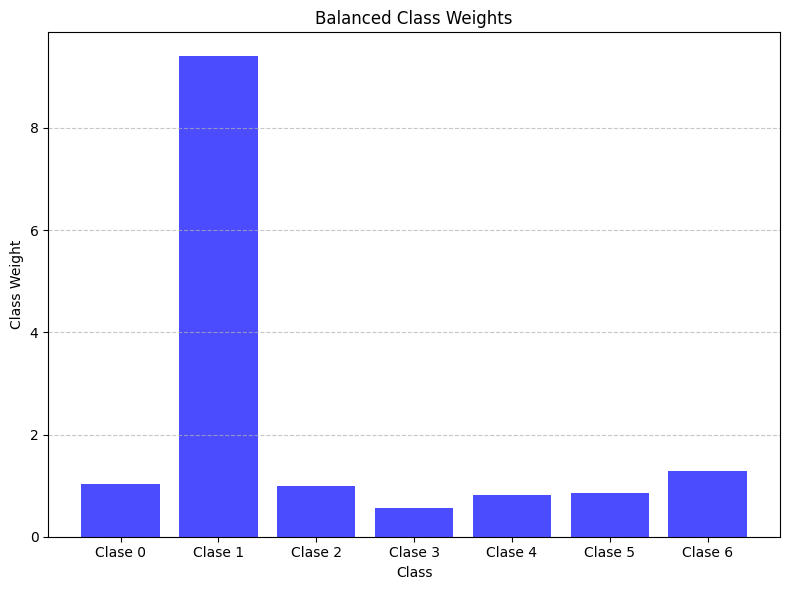

In [32]:

plt.figure(figsize=(8, 6))
plt.bar(class_weights_dict.keys(), class_weights_dict.values(), color='b', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Class Weight')
plt.title('Balanced Class Weights')
plt.xticks(list(class_weights_dict.keys()), labels=[f'Clase {k}' for k in class_weights_dict.keys()])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [31]:
class_indices = train_generator.class_indices
class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

# Models

## Model 1 66.49%

In [15]:
model_MoreData = tf.keras.Sequential([

        tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',input_shape=(48,48,3)),
        tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu' ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(128,(5,5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=L2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(7, activation='softmax')
    ])

In [16]:
optimiser = tf.keras.optimizers.Adam(learning_rate=1e-4)
model_MoreData.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_MoreData.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       2

In [ ]:
model_MoreData

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test1_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test1_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test1_MoreData/64batch', exist_ok=True)



log_dir = "logs/test1_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [ ]:
historytest1_MoreData = model_MoreData.fit(x = train_generator,epochs = 300,validation_data = val_generator, class_weight=class_weights_dict, callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 9.9602 - accuracy: 0.1587
Epoch 1: val_accuracy improved from -inf to 0.16670, saving model to models/test1_MoreData/64batch\best_model_ModelPaper2_1_0.1667.h5
359/359 [==============================] - 47s 125ms/step - loss: 9.9602 - accuracy: 0.1587 - val_loss: 9.3066 - val_accuracy: 0.1667 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 9.2297 - accuracy: 0.1724
Epoch 2: val_accuracy improved from 0.16670 to 0.19648, saving model to models/test1_MoreData/64batch\best_model_ModelPaper2_2_0.1965.h5
359/359 [==============================] - 43s 120ms/step - loss: 9.2297 - accuracy: 0.1724 - val_loss: 8.6808 - val_accuracy: 0.1965 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 8.5392 - accuracy: 0.1790
Epoch 3: val_accuracy did not improve from 0.19648
359/359 [==============================] - 44s 121ms/step - loss: 8.5392 - accuracy: 

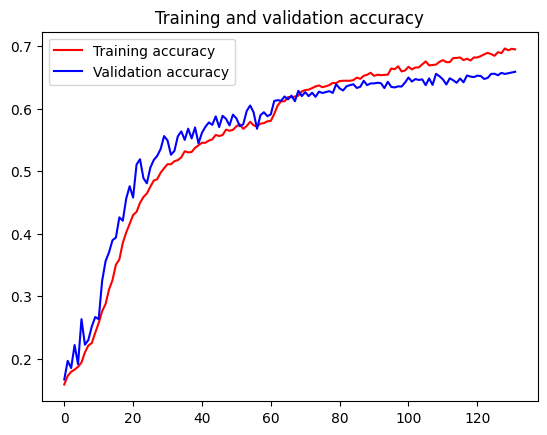

<Figure size 640x480 with 0 Axes>

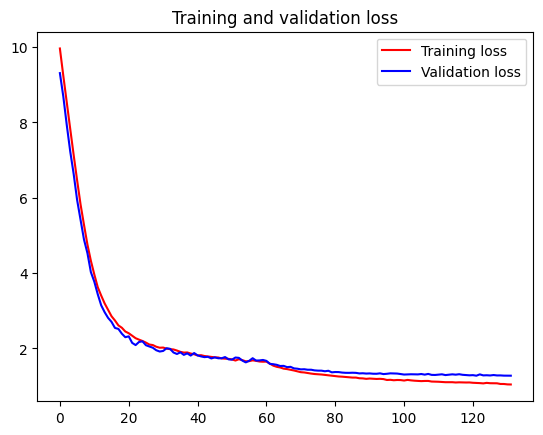

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest1_MoreData.history['accuracy']
val_acc = historytest1_MoreData.history['val_accuracy']
loss = historytest1_MoreData.history['loss']
val_loss = historytest1_MoreData.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

model_moreData_load = tf.keras.models.load_model('models/test1_MoreData/64batch/best_model_ModelPaper2_132_0.6593.h5')

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model_moreData_load.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 28s 194ms/step
              precision    recall  f1-score   support

           0       0.54      0.65      0.59       958
           1       0.56      0.68      0.61       111
           2       0.58      0.38      0.46      1024
           3       0.89      0.85      0.87      1774
           4       0.57      0.72      0.64      1233
           5       0.61      0.47      0.53      1247
           6       0.72      0.85      0.78       831

    accuracy                           0.66      7178
   macro avg       0.64      0.66      0.64      7178
weighted avg       0.67      0.66      0.66      7178

<function confusion_matrix at 0x000001870AF1AEF0>


In [ ]:
model_MoreData.evaluate(test_generator)

113/113 [==============================] - 13s 111ms/step - loss: 1.2603 - accuracy: 0.6649


[1.2603180408477783, 0.6649484634399414]

## Model 2 58.63%

In [ ]:
from keras.applications import ResNet50V2
from keras.optimizers import Adamax

input_shape = (48, 48, 3)

base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)

model2_MoreData = Sequential([
                    #tf.keras.layers.Resizing(75,75),
                    base_model,
                    BatchNormalization(),
                    GlobalAveragePooling2D(),
                    Dense(128, activation='relu'),
                    Dropout(0.5),
                    Dense(128, activation='relu'),
                    Dropout(0.5),
                    Dense(7, activation='softmax')
                  ])

optimizer = Adamax(learning_rate=1e-4)

model2_MoreData.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model2_MoreData.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 batch_normalization_63 (Bat  (None, 2, 2, 2048)       8192      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_37 (Dense)            (None, 128)               262272    
                                                                 
 dropout_70 (Dropout)        (None, 128)               0         
                                                                 
 dense_38 (Dense)            (None, 128)             

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test2_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test2_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test2_MoreData/64batch', exist_ok=True)



log_dir = "logs/test2_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [ ]:
historytest2_MoreData = model2_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback, reduce_lr])

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 2.3210 - accuracy: 0.1469
Epoch 1: val_accuracy improved from -inf to 0.14632, saving model to models/test2_MoreData/64batch\best_model_ModelPaper2_1_0.1463.h5
359/359 [==============================] - 64s 155ms/step - loss: 2.3210 - accuracy: 0.1469 - val_loss: 1.9672 - val_accuracy: 0.1463 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 2.0325 - accuracy: 0.1501
Epoch 2: val_accuracy did not improve from 0.14632
359/359 [==============================] - 51s 141ms/step - loss: 2.0325 - accuracy: 0.1501 - val_loss: 1.9488 - val_accuracy: 0.1430 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 1.9771 - accuracy: 0.1541
Epoch 3: val_accuracy improved from 0.14632 to 0.16704, saving model to models/test2_MoreData/64batch\best_model_ModelPaper2_3_0.1670.h5
359/359 [==============================] - 52s 146ms/step - loss: 1.9771 - accuracy: 

In [ ]:
model2_MoreData = tf.keras.models.load_model('models/test2_MoreData/64batch/best_model_ModelPaper2_68_0.5788.h5')
model2_MoreData.evaluate(test_generator)

113/113 [==============================] - 6s 46ms/step - loss: 1.1586 - accuracy: 0.5864


[1.1586318016052246, 0.5863750576972961]

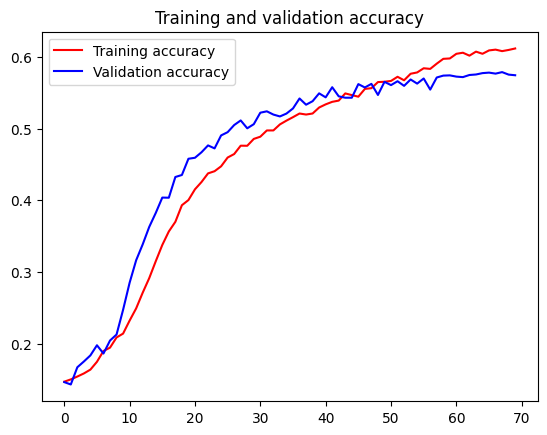

<Figure size 640x480 with 0 Axes>

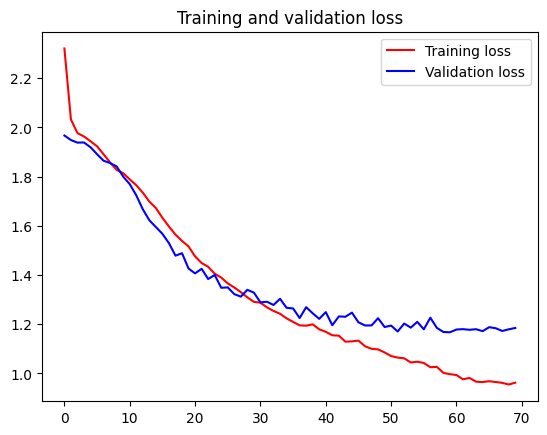

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest2_MoreData.history['accuracy']
val_acc = historytest2_MoreData.history['val_accuracy']
loss = historytest2_MoreData.history['loss']
val_loss = historytest2_MoreData.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 3 64.44%

In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50V2, VGG19
from keras.regularizers import l2



input_shape = (48, 48, 3)

base_model = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)

model3_MoreData = Sequential([
                    base_model,
                    BatchNormalization(),
                    GlobalAveragePooling2D(),
                    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
                    Dropout(0.4),
                    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
                    Dropout(0.4),
                    Dense(7, activation='softmax')
                  ])

optimizer = Adamax(learning_rate=1e-4)

model3_MoreData.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model3_MoreData.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 batch_normalization_72 (Bat  (None, 1, 1, 512)        2048      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_49 (Dense)            (None, 256)               131328    
                                                                 
 dropout_82 (Dropout)        (None, 256)               0         
                                                                 
 dense_50 (Dense)            (None, 128)             

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test3_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test3_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test3_MoreData/64batch', exist_ok=True)



log_dir = "logs/test3_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [ ]:
historytest3_MoreData = model3_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 2.4205 - accuracy: 0.1604
Epoch 1: val_accuracy improved from -inf to 0.15729, saving model to models/test3_MoreData/64batch\best_model_ModelPaper2_1_0.1573.h5
359/359 [==============================] - 63s 168ms/step - loss: 2.4205 - accuracy: 0.1604 - val_loss: 2.5168 - val_accuracy: 0.1573 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 2.2789 - accuracy: 0.2170
Epoch 2: val_accuracy improved from 0.15729 to 0.25553, saving model to models/test3_MoreData/64batch\best_model_ModelPaper2_2_0.2555.h5
359/359 [==============================] - 57s 159ms/step - loss: 2.2789 - accuracy: 0.2170 - val_loss: 2.1640 - val_accuracy: 0.2555 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 2.1738 - accuracy: 0.2679
Epoch 3: val_accuracy improved from 0.25553 to 0.28479, saving model to models/test3_MoreData/64batch\best_model_ModelPaper2_3_0.2848.h5

In [ ]:
model3_MoreData.evaluate(test_generator)

113/113 [==============================] - 9s 80ms/step - loss: 1.1479 - accuracy: 0.6445


[1.1479302644729614, 0.6444692015647888]

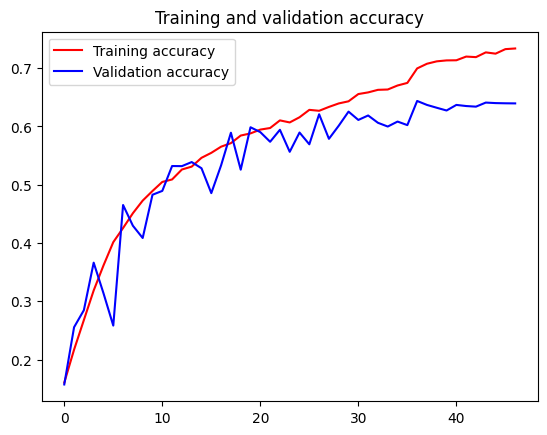

<Figure size 640x480 with 0 Axes>

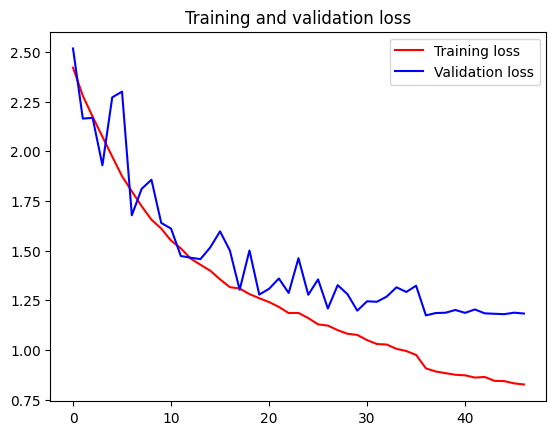

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest3_MoreData.history['accuracy']
val_acc = historytest3_MoreData.history['val_accuracy']
loss = historytest3_MoreData.history['loss']
val_loss = historytest3_MoreData.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 4 55.11%

In [ ]:

input_shape = (48, 48, 3)
input_layer = Input(shape=input_shape)

#Modelo VGGNet
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(2048, activation='relu', kernel_regularizer=L2(0.001))(x)
x = Dropout(0.5)(x)

output_layer = Dense(7, activation='softmax')(x)


model4_moreData = Model(inputs=input_layer, outputs=output_layer)

model4_moreData.summary()

model4_moreData.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_72 (Conv2D)          (None, 48, 48, 64)        1792      
                                                                 
 conv2d_73 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_73 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_84 (Dropout)        (None, 24, 24, 64)        0     

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test4_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test4_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test4_MoreData/64batch', exist_ok=True)



log_dir = "logs/test4_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [ ]:
historytest4_moreData = model4_moreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr],
    shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 2.2665 - accuracy: 0.1551
Epoch 1: val_accuracy improved from -inf to 0.01568, saving model to models/test4_MoreData/64batch\best_model_ModelPaper2_1_0.0157.h5
359/359 [==============================] - 44s 115ms/step - loss: 2.2665 - accuracy: 0.1551 - val_loss: 2.2224 - val_accuracy: 0.0157 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 2.1764 - accuracy: 0.1668
Epoch 2: val_accuracy improved from 0.01568 to 0.23027, saving model to models/test4_MoreData/64batch\best_model_ModelPaper2_2_0.2303.h5
359/359 [==============================] - 42s 116ms/step - loss: 2.1764 - accuracy: 0.1668 - val_loss: 2.1439 - val_accuracy: 0.2303 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 2.1424 - accuracy: 0.1838
Epoch 3: val_accuracy did not improve from 0.23027
359/359 [==============================] - 41s 114ms/step - loss: 2.1424 - accuracy: 

In [ ]:
model4_moreData.evaluate(test_generator)

113/113 [==============================] - 6s 53ms/step - loss: 1.2110 - accuracy: 0.5511


[1.2109644412994385, 0.5511284470558167]

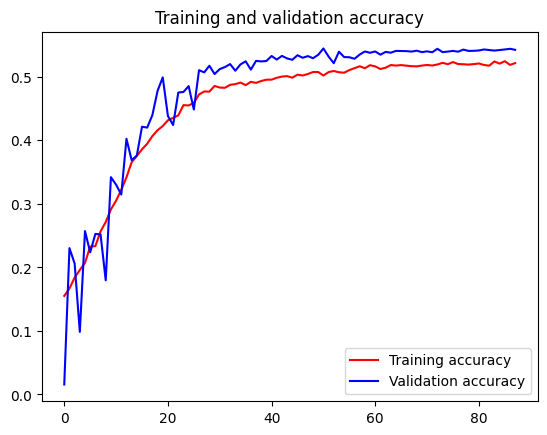

<Figure size 640x480 with 0 Axes>

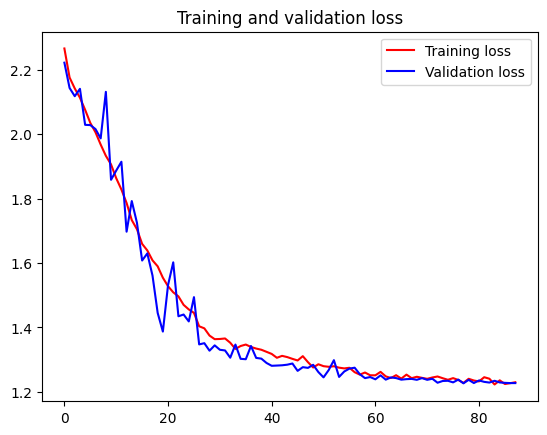

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest4_moreData.history['accuracy']
val_acc = historytest4_moreData.history['val_accuracy']
loss = historytest4_moreData.history['loss']
val_loss = historytest4_moreData.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 5 58.17%

In [ ]:
from keras.layers import Input, Conv2D, BatchNormalization, Dropout, Dense,Flatten
from keras.optimizers import Adam

InputKeras = Input(shape=(48,48,3))


x = Conv2D(256, (3,3), activation="relu",padding="same")(InputKeras)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.25)(x)

x = Conv2D(256, (3,3), activation="relu",padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.25)(x)

x = Conv2D(256, (3,3), activation="relu",padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.25)(x)

x = Conv2D(256, (3,3), activation="relu",padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(1792, activation="relu")(x)
x = Dropout(0.5)(x)
prediction = Dense(7, activation="softmax")(x)

Model5_MoreData = Model(inputs=InputKeras, outputs=prediction)

Model5_MoreData.compile(loss="categorical_crossentropy", optimizer=Adam(1e-4), metrics=["accuracy"])

Model5_MoreData.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_82 (Conv2D)          (None, 48, 48, 256)       7168      
                                                                 
 batch_normalization_78 (Bat  (None, 48, 48, 256)      1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 24, 24, 256)      0         
 g2D)                                                            
                                                                 
 dropout_90 (Dropout)        (None, 24, 24, 256)       0         
                                                                 
 conv2d_83 (Conv2D)          (None, 24, 24, 256)       5900

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test5_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test5_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test5_MoreData/64batch', exist_ok=True)



log_dir = "logs/test5_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [ ]:
historytest5_moreData = Model5_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr],
    shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 2.5286 - accuracy: 0.1746
Epoch 1: val_accuracy improved from -inf to 0.17297, saving model to models/test5_MoreData/64batch\best_model_ModelPaper2_1_0.1730.h5
359/359 [==============================] - 46s 123ms/step - loss: 2.5286 - accuracy: 0.1746 - val_loss: 3.8237 - val_accuracy: 0.1730 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 1.9810 - accuracy: 0.1910
Epoch 2: val_accuracy improved from 0.17297 to 0.21913, saving model to models/test5_MoreData/64batch\best_model_ModelPaper2_2_0.2191.h5
359/359 [==============================] - 43s 120ms/step - loss: 1.9810 - accuracy: 0.1910 - val_loss: 2.2440 - val_accuracy: 0.2191 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 1.9190 - accuracy: 0.2054
Epoch 3: val_accuracy improved from 0.21913 to 0.24421, saving model to models/test5_MoreData/64batch\best_model_ModelPaper2_3_0.2442.h5

In [ ]:
Model5_MoreData.evaluate(test_generator)

113/113 [==============================] - 5s 45ms/step - loss: 1.1152 - accuracy: 0.5818


[1.1152089834213257, 0.5817776322364807]

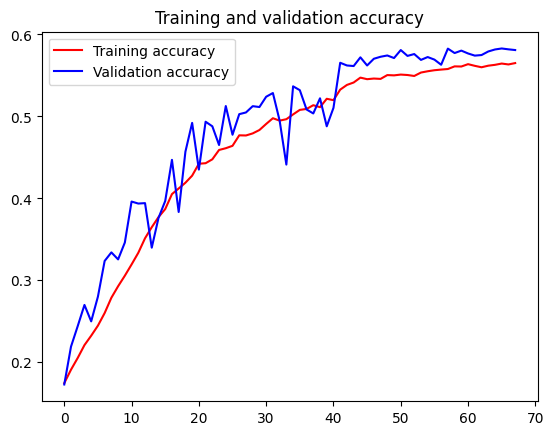

<Figure size 640x480 with 0 Axes>

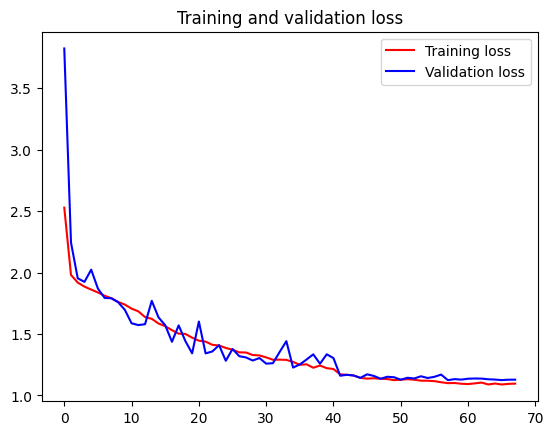

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest5_moreData.history['accuracy']
val_acc = historytest5_moreData.history['val_accuracy']
loss = historytest5_moreData.history['loss']
val_loss = historytest5_moreData.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 6 65.40%

In [ ]:
fernet = tf.keras.models.Sequential()   

fernet.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,3)))
fernet.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
fernet.add(BatchNormalization())
fernet.add(MaxPooling2D(2, 2))
fernet.add(Dropout(0.3))

fernet.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
fernet.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
fernet.add(BatchNormalization())
fernet.add(MaxPooling2D(pool_size=(2, 2)))
fernet.add(Dropout(0.3))

fernet.add(Flatten())
fernet.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
fernet.add(Dropout(0.5))
    
fernet.add(Dense(7, activation='softmax'))

fernet.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])


In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test6_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test6_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test6_MoreData/64batch', exist_ok=True)



log_dir = "logs/test6_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)

In [ ]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = val_generator.n // val_generator.batch_size

hist = fernet.fit(x=train_generator,
                 validation_data=val_generator,
                 epochs=300,
                 callbacks=[early_stopping,model_checkpoint,tensorboard_callback,reduce_lr],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/300
358/358 [==============================] - ETA: 0s - loss: 20.2265 - accuracy: 0.2486
Epoch 1: val_accuracy improved from -inf to 0.30144, saving model to models/test6_MoreData/64batch\best_model_ModelPaper2_1_0.3014.h5
358/358 [==============================] - 69s 188ms/step - loss: 20.2265 - accuracy: 0.2486 - val_loss: 15.5489 - val_accuracy: 0.3014 - lr: 1.0000e-04
Epoch 2/300
358/358 [==============================] - ETA: 0s - loss: 11.6431 - accuracy: 0.2806
Epoch 2: val_accuracy improved from 0.30144 to 0.37254, saving model to models/test6_MoreData/64batch\best_model_ModelPaper2_2_0.3725.h5
358/358 [==============================] - 61s 170ms/step - loss: 11.6431 - accuracy: 0.2806 - val_loss: 8.5922 - val_accuracy: 0.3725 - lr: 1.0000e-04
Epoch 3/300
358/358 [==============================] - ETA: 0s - loss: 6.8680 - accuracy: 0.3120
Epoch 3: val_accuracy improved from 0.37254 to 0.38167, saving model to models/test6_MoreData/64batch\best_model_ModelPaper2_3_0.38

In [ ]:
fernet = tf.keras.models.load_model(r'C:\Users\bryan\OneDrive\Escritorio\Tesis\Codigo tesis\Imagen\Code 2\code3\models\test6_MoreData\64batch\best_model_ModelPaper2_37_0.6162.h5')
fernet.evaluate(test_generator)

113/113 [==============================] - 5s 40ms/step - loss: 1.4801 - accuracy: 0.6127


[1.480120062828064, 0.6127054691314697]

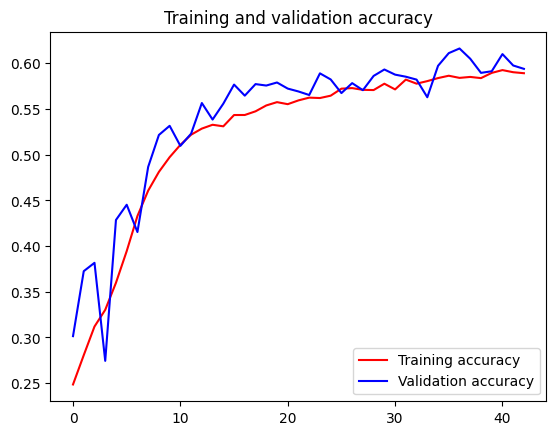

<Figure size 640x480 with 0 Axes>

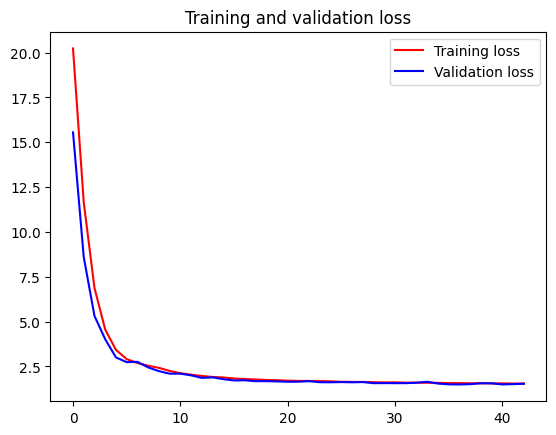

In [ ]:
import matplotlib.pyplot as plt
accuracy = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

### Segunda prueba con Reduce

In [ ]:
model6_MoreData = tf.keras.models.Sequential()   

model6_MoreData.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,3)))
model6_MoreData.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model6_MoreData.add(BatchNormalization())
model6_MoreData.add(MaxPooling2D(2, 2))
model6_MoreData.add(Dropout(0.3))

model6_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model6_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model6_MoreData.add(BatchNormalization())
model6_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model6_MoreData.add(Dropout(0.3))

model6_MoreData.add(Flatten())
model6_MoreData.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
model6_MoreData.add(Dropout(0.5))
    
model6_MoreData.add(Dense(7, activation='softmax'))

model6_MoreData.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test6_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test6_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test6_MoreData/64batch', exist_ok=True)



log_dir = "logs/test6_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [ ]:
historytest6_MoreData = model6_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 20.5996 - accuracy: 0.1738
Epoch 1: val_accuracy improved from -inf to 0.21094, saving model to models/test6_MoreData/64batch\best_model_ModelPaper2_1_0.2109.h5
359/359 [==============================] - 55s 150ms/step - loss: 20.5996 - accuracy: 0.1738 - val_loss: 17.6076 - val_accuracy: 0.2109 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 12.7117 - accuracy: 0.1805
Epoch 2: val_accuracy improved from 0.21094 to 0.25431, saving model to models/test6_MoreData/64batch\best_model_ModelPaper2_2_0.2543.h5
359/359 [==============================] - 64s 177ms/step - loss: 12.7117 - accuracy: 0.1805 - val_loss: 10.0689 - val_accuracy: 0.2543 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 8.3226 - accuracy: 0.2176
Epoch 3: val_accuracy improved from 0.25431 to 0.25832, saving model to models/test6_MoreData/64batch\best_model_ModelPaper2_3_0.2

In [ ]:
model6_MoreData.evaluate(test_generator)

113/113 [==============================] - 34s 302ms/step - loss: 1.1634 - accuracy: 0.6541


[1.1634430885314941, 0.6540819406509399]

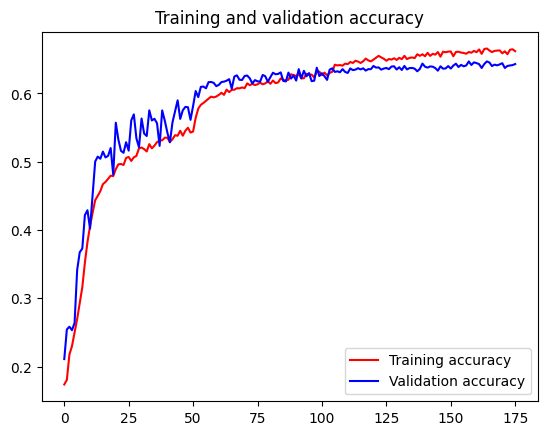

<Figure size 640x480 with 0 Axes>

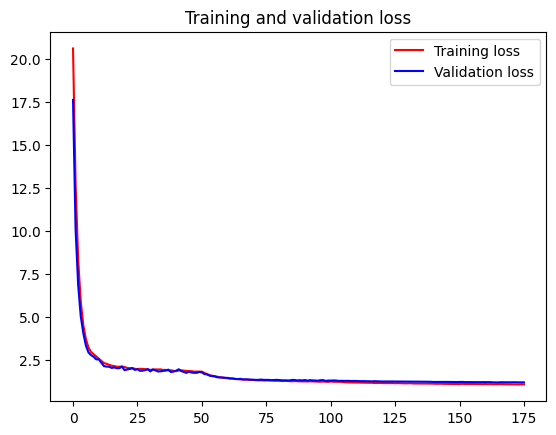

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest6_MoreData.history['accuracy']
val_acc = historytest6_MoreData.history['val_accuracy']
loss = historytest6_MoreData.history['loss']
val_loss = historytest6_MoreData.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 7 67.28%

In [ ]:
model8_MoreData = tf.keras.models.Sequential()   

model8_MoreData.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,3)))
model8_MoreData.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model8_MoreData.add(BatchNormalization())
model8_MoreData.add(MaxPooling2D(2, 2))
model8_MoreData.add(Dropout(0.3))

model8_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData.add(BatchNormalization())
model8_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData.add(Dropout(0.3))

model8_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData.add(BatchNormalization())
model8_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData.add(Dropout(0.3))

model8_MoreData.add(Flatten())
model8_MoreData.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
model8_MoreData.add(Dropout(0.5))
    
model8_MoreData.add(Dense(7, activation='softmax'))

model8_MoreData.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test8_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test8_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test8_MoreData/64batch', exist_ok=True)



log_dir = "logs/test8_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [ ]:
historytest8_MoreData = model8_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 23.3480 - accuracy: 0.1724
Epoch 1: val_accuracy improved from -inf to 0.02160, saving model to models/test8_MoreData/64batch\best_model_ModelPaper2_1_0.0216.h5
359/359 [==============================] - 48s 127ms/step - loss: 23.3480 - accuracy: 0.1724 - val_loss: 22.1749 - val_accuracy: 0.0216 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 19.3176 - accuracy: 0.1836
Epoch 2: val_accuracy improved from 0.02160 to 0.26825, saving model to models/test8_MoreData/64batch\best_model_ModelPaper2_2_0.2682.h5
359/359 [==============================] - 42s 118ms/step - loss: 19.3176 - accuracy: 0.1836 - val_loss: 17.4401 - val_accuracy: 0.2682 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 15.7457 - accuracy: 0.2066
Epoch 3: val_accuracy did not improve from 0.26825
359/359 [==============================] - 43s 119ms/step - loss: 15.7457 - ac

In [ ]:
model8_MoreData.evaluate(test_generator)

113/113 [==============================] - 9s 81ms/step - loss: 1.1480 - accuracy: 0.6729


[1.1479512453079224, 0.6728894114494324]

In [32]:
from sklearn.metrics import classification_report, confusion_matrix

model_moreData8_load1 = tf.keras.models.load_model(r'models/test8_MoreData/64batch/best_model_ModelPaper2_108_0.6600.h5')

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model_moreData8_load1.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 4s 37ms/step
              precision    recall  f1-score   support

           0       0.55      0.65      0.60       958
           1       0.58      0.65      0.61       111
           2       0.55      0.40      0.46      1024
           3       0.89      0.84      0.87      1774
           4       0.58      0.72      0.64      1233
           5       0.58      0.47      0.52      1247
           6       0.74      0.83      0.78       831

    accuracy                           0.67      7178
   macro avg       0.64      0.65      0.64      7178
weighted avg       0.67      0.67      0.66      7178

<function confusion_matrix at 0x000001870AF1AEF0>


In [33]:
model_moreData8_load1.evaluate(test_generator)

113/113 [==============================] - 5s 40ms/step - loss: 1.1665 - accuracy: 0.6656


[1.166458010673523, 0.6656450033187866]

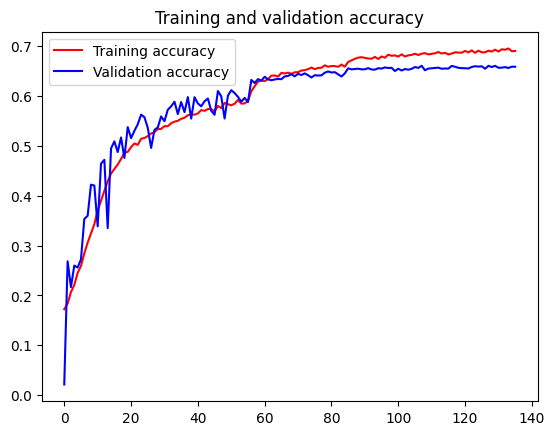

<Figure size 640x480 with 0 Axes>

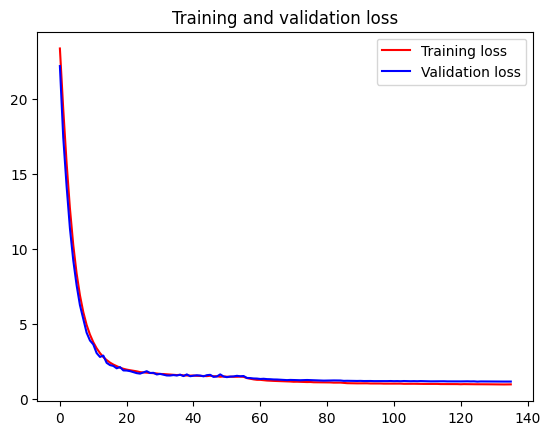

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest8_MoreData.history['accuracy']
val_acc = historytest8_MoreData.history['val_accuracy']
loss = historytest8_MoreData.history['loss']
val_loss = historytest8_MoreData.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 8 53.83%

In [ ]:
model9_MoreData = tf.keras.models.Sequential()   

model9_MoreData.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,3)))
model9_MoreData.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model9_MoreData.add(BatchNormalization())
model9_MoreData.add(MaxPooling2D(2, 2))
model9_MoreData.add(Dropout(0.3))

model9_MoreData.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model9_MoreData.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model9_MoreData.add(BatchNormalization())
model9_MoreData.add(MaxPooling2D(2, 2))
model9_MoreData.add(Dropout(0.3))

model9_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model9_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding="same", kernel_regularizer=L2(0.01)))
model9_MoreData.add(BatchNormalization())
model9_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model9_MoreData.add(Dropout(0.3))

model9_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model9_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding="same", kernel_regularizer=L2(0.01)))
model9_MoreData.add(BatchNormalization())
model9_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model9_MoreData.add(Dropout(0.3))

model9_MoreData.add(Flatten())
model9_MoreData.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
model9_MoreData.add(Dropout(0.5))
    
model9_MoreData.add(Dense(7, activation='softmax'))

model9_MoreData.compile(optimizer=Adam(learning_rate=1e-3), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test9_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test9_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test9_MoreData/64batch', exist_ok=True)



log_dir = "logs/test9_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [ ]:
historytest9_MoreData = model9_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 12.2057 - accuracy: 0.1566
Epoch 1: val_accuracy improved from -inf to 0.08013, saving model to models/test9_MoreData/64batch\best_model_ModelPaper2_1_0.0801.h5
359/359 [==============================] - 44s 116ms/step - loss: 12.2057 - accuracy: 0.1566 - val_loss: 6.0364 - val_accuracy: 0.0801 - lr: 0.0010
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 4.0653 - accuracy: 0.1744
Epoch 2: val_accuracy improved from 0.08013 to 0.18882, saving model to models/test9_MoreData/64batch\best_model_ModelPaper2_2_0.1888.h5
359/359 [==============================] - 42s 117ms/step - loss: 4.0653 - accuracy: 0.1744 - val_loss: 3.2363 - val_accuracy: 0.1888 - lr: 0.0010
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 2.9232 - accuracy: 0.1722
Epoch 3: val_accuracy did not improve from 0.18882
359/359 [==============================] - 43s 120ms/step - loss: 2.9232 - accuracy: 0.1722

In [ ]:
model9_MoreData.evaluate(test_generator)

113/113 [==============================] - 14s 120ms/step - loss: 1.2345 - accuracy: 0.5383


[1.2344971895217896, 0.5383114814758301]

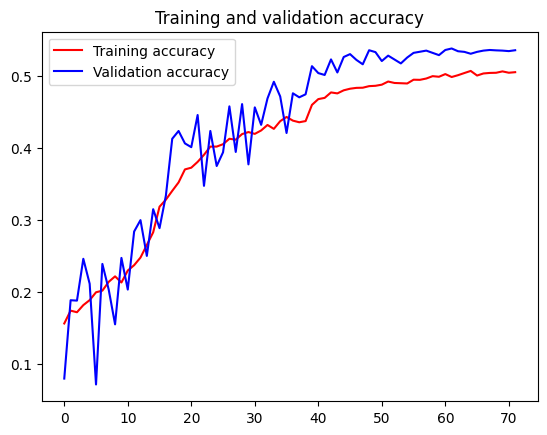

<Figure size 640x480 with 0 Axes>

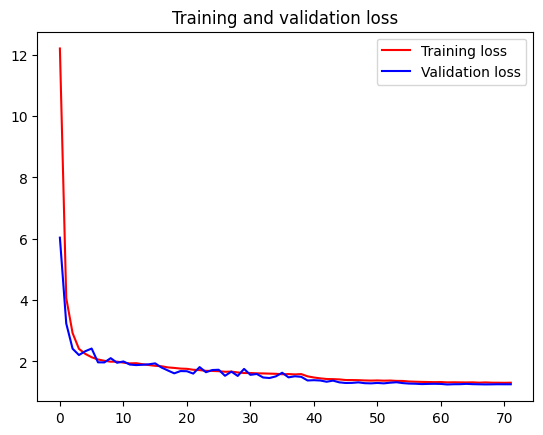

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest9_MoreData.history['accuracy']
val_acc = historytest9_MoreData.history['val_accuracy']
loss = historytest9_MoreData.history['loss']
val_loss = historytest9_MoreData.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 9 54.75%

In [ ]:
model10_MoreData = tf.keras.models.Sequential()   

model10_MoreData.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,3)))
model10_MoreData.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model10_MoreData.add(BatchNormalization())
model10_MoreData.add(MaxPooling2D(2, 2))
model10_MoreData.add(Dropout(0.3))

model10_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model10_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model10_MoreData.add(BatchNormalization())
model10_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model10_MoreData.add(Dropout(0.3))

model10_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model10_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model10_MoreData.add(BatchNormalization())
model10_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model10_MoreData.add(Dropout(0.3))

model10_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model10_MoreData.add(Conv2D(512, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model10_MoreData.add(BatchNormalization())
model10_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model10_MoreData.add(Dropout(0.3))

model10_MoreData.add(Flatten())
model10_MoreData.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
model10_MoreData.add(Dropout(0.5))
    
model10_MoreData.add(Dense(7, activation='softmax'))

model10_MoreData.compile(optimizer=Adam(learning_rate=1e-3), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test10_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test10_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test10_MoreData/64batch', exist_ok=True)



log_dir = "logs/test10_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [ ]:
historytest10_MoreData = model10_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 12.0142 - accuracy: 0.1597
Epoch 1: val_accuracy improved from -inf to 0.14963, saving model to models/test10_MoreData/64batch\best_model_ModelPaper2_1_0.1496.h5
359/359 [==============================] - 74s 188ms/step - loss: 12.0142 - accuracy: 0.1597 - val_loss: 5.4298 - val_accuracy: 0.1496 - lr: 0.0010
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 3.6945 - accuracy: 0.1575
Epoch 2: val_accuracy improved from 0.14963 to 0.14980, saving model to models/test10_MoreData/64batch\best_model_ModelPaper2_2_0.1498.h5
359/359 [==============================] - 42s 117ms/step - loss: 3.6945 - accuracy: 0.1575 - val_loss: 2.6200 - val_accuracy: 0.1498 - lr: 0.0010
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 2.3642 - accuracy: 0.1626
Epoch 3: val_accuracy did not improve from 0.14980
359/359 [==============================] - 42s 117ms/step - loss: 2.3642 - accuracy: 0.16

In [ ]:
model10_MoreData.evaluate(test_generator)

113/113 [==============================] - 10s 86ms/step - loss: 1.2837 - accuracy: 0.5475


[1.283663272857666, 0.5475062727928162]

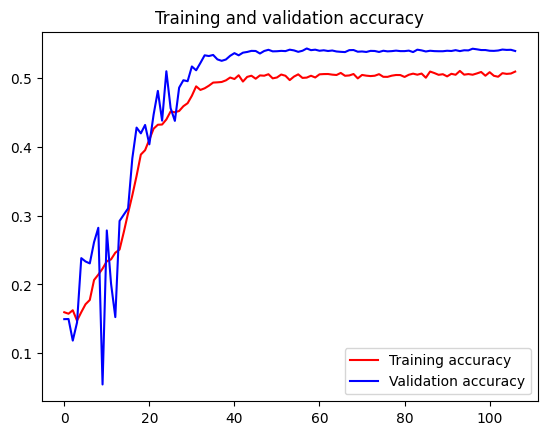

<Figure size 640x480 with 0 Axes>

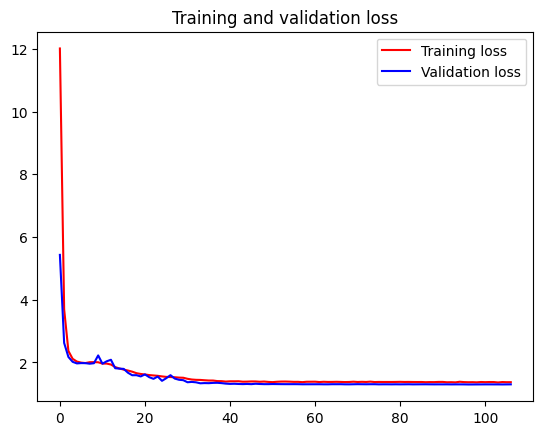

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest10_MoreData.history['accuracy']
val_acc = historytest10_MoreData.history['val_accuracy']
loss = historytest10_MoreData.history['loss']
val_loss = historytest10_MoreData.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Other ImageDataGenerator

### More Rotation_range 63.59%

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'fer2013/train'
test_dir = 'fer2013/test'


train_datagen2 = ImageDataGenerator(
    rescale=1/255,                
    rotation_range=20,            
    horizontal_flip=True,         
    vertical_flip=True,
    validation_split=0.2          
)

val_datagen2 = ImageDataGenerator(
    rescale=1/255, 
    validation_split=0.2
)

test_datagen2 = ImageDataGenerator(
    rescale=1/255
)

train_generator2 = train_datagen2.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       
    color_mode='grayscale',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    subset="training",              
    shuffle=True
)

val_generator2 = val_datagen2.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       
    color_mode='grayscale',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    subset="validation",            
    shuffle=False
)

test_generator2 = test_datagen2.flow_from_directory(
    directory=test_dir,
    target_size=(img_shape, img_shape),       
    color_mode='grayscale',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    shuffle=False
)




classes = np.array(train_generator2.classes)


class_weights = compute_class_weight(
    class_weight='balanced',  
    classes=np.unique(classes),  
    y=classes  
)

class_weights_dict = dict(enumerate(class_weights))

print("Class Weights Dictionary:", class_weights_dict)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class Weights Dictionary: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


In [ ]:
model8_MoreData2 = tf.keras.models.Sequential()   

model8_MoreData2.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,1)))
model8_MoreData2.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model8_MoreData2.add(BatchNormalization())
model8_MoreData2.add(MaxPooling2D(2, 2))
model8_MoreData2.add(Dropout(0.3))

model8_MoreData2.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData2.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData2.add(BatchNormalization())
model8_MoreData2.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData2.add(Dropout(0.3))

model8_MoreData2.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData2.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData2.add(BatchNormalization())
model8_MoreData2.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData2.add(Dropout(0.3))

model8_MoreData2.add(Flatten())
model8_MoreData2.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
model8_MoreData2.add(Dropout(0.5))
    
model8_MoreData2.add(Dense(7, activation='softmax'))

model8_MoreData2.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test8_MoreData2_otherImageGenerator/64batch', exist_ok=True)


checkpoint_path = 'models/test8_MoreData2_otherImageGenerator/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test8_MoreData2_otherImageGenerator/64batch', exist_ok=True)



log_dir = "logs/test8_MoreData2_otherImageGenerator/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [ ]:
historytest8_MoreData2 = model8_MoreData2.fit(
    x = train_generator2,
    epochs = 300,
    validation_data = val_generator2, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 23.1925 - accuracy: 0.1700
Epoch 1: val_accuracy improved from -inf to 0.14301, saving model to models/test8_MoreData2_otherImageGenerator/64batch\best_model_ModelPaper2_1_0.1430.h5
359/359 [==============================] - 31s 82ms/step - loss: 23.1925 - accuracy: 0.1700 - val_loss: 21.3216 - val_accuracy: 0.1430 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 18.9990 - accuracy: 0.1834
Epoch 2: val_accuracy improved from 0.14301 to 0.25553, saving model to models/test8_MoreData2_otherImageGenerator/64batch\best_model_ModelPaper2_2_0.2555.h5
359/359 [==============================] - 29s 81ms/step - loss: 18.9990 - accuracy: 0.1834 - val_loss: 17.0335 - val_accuracy: 0.2555 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 15.2933 - accuracy: 0.2041
Epoch 3: val_accuracy did not improve from 0.25553
359/359 [=============================

In [ ]:
model8_MoreData2.evaluate(test_generator2)

113/113 [==============================] - 8s 71ms/step - loss: 1.2452 - accuracy: 0.6360


[1.2452232837677002, 0.6359710097312927]

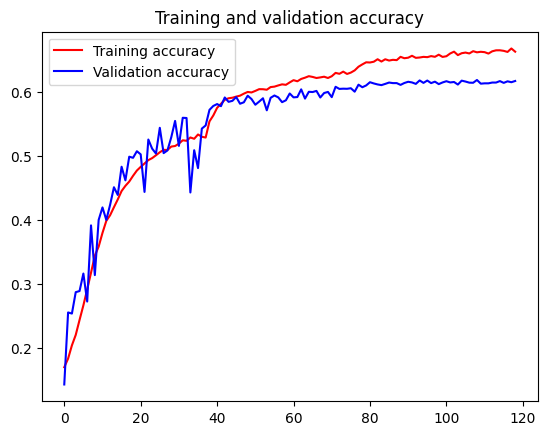

<Figure size 640x480 with 0 Axes>

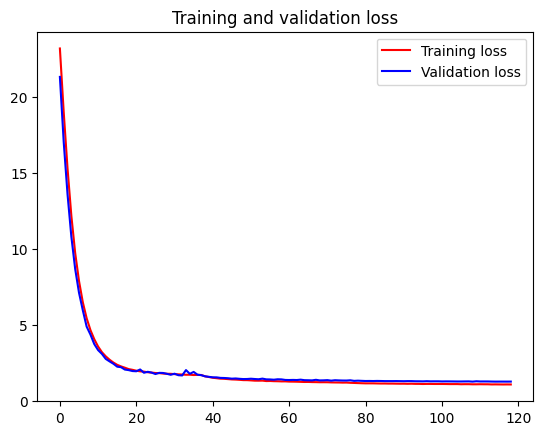

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest8_MoreData2.history['accuracy']
val_acc = historytest8_MoreData2.history['val_accuracy']
loss = historytest8_MoreData2.history['loss']
val_loss = historytest8_MoreData2.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

### More Hiperparameters 64.58%

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'fer2013/train'
test_dir = 'fer2013/test'


train_datagen3 = ImageDataGenerator(
    rescale=1/255,                
    rotation_range=25,            
    zoom_range=0.2,               
    width_shift_range=0.2,        
    height_shift_range=0.2,           
    horizontal_flip=True,         
    fill_mode='nearest',          
    validation_split=0.2          
)

val_datagen3 = ImageDataGenerator(
    rescale=1/255, 
    validation_split=0.2
)

test_datagen3 = ImageDataGenerator(
    rescale=1/255
)


train_generator3 = train_datagen3.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    subset="training",              
    shuffle=True
)

val_generator3 = val_datagen3.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    subset="validation",            
    shuffle=False
)

test_generator3 = test_datagen3.flow_from_directory(
    directory=test_dir,
    target_size=(img_shape, img_shape),       
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    shuffle=False
)




classes = np.array(train_generator3.classes)


class_weights = compute_class_weight(
    class_weight='balanced',  
    classes=np.unique(classes),  
    y=classes  
)

class_weights_dict = dict(enumerate(class_weights))

print("Class Weights Dictionary:", class_weights_dict)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class Weights Dictionary: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


In [ ]:
model8_MoreData3 = tf.keras.models.Sequential()   

model8_MoreData3.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,3)))
model8_MoreData3.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model8_MoreData3.add(BatchNormalization())
model8_MoreData3.add(MaxPooling2D(2, 2))
model8_MoreData3.add(Dropout(0.3))

model8_MoreData3.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData3.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData3.add(BatchNormalization())
model8_MoreData3.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData3.add(Dropout(0.3))

model8_MoreData3.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData3.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData3.add(BatchNormalization())
model8_MoreData3.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData3.add(Dropout(0.3))

model8_MoreData3.add(Flatten())
model8_MoreData3.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
model8_MoreData3.add(Dropout(0.5))
    
model8_MoreData3.add(Dense(7, activation='softmax'))

model8_MoreData3.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test8_MoreData3_otherImageGenerator3/64batch', exist_ok=True)


checkpoint_path = 'models/test8_MoreData3_otherImageGenerator3/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test8_MoreData3_otherImageGenerator3/64batch', exist_ok=True)



log_dir = "logs/test8_MoreData3_otherImageGenerator3/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [ ]:
historytest8_MoreData3 = model8_MoreData3.fit(
    x = train_generator3,
    epochs = 300,
    validation_data = val_generator3, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 23.4614 - accuracy: 0.1594
Epoch 1: val_accuracy improved from -inf to 0.01533, saving model to models/test8_MoreData3_otherImageGenerator3/64batch\best_model_ModelPaper2_1_0.0153.h5
359/359 [==============================] - 47s 125ms/step - loss: 23.4614 - accuracy: 0.1594 - val_loss: 23.4568 - val_accuracy: 0.0153 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 19.3927 - accuracy: 0.1739
Epoch 2: val_accuracy improved from 0.01533 to 0.17001, saving model to models/test8_MoreData3_otherImageGenerator3/64batch\best_model_ModelPaper2_2_0.1700.h5
359/359 [==============================] - 43s 121ms/step - loss: 19.3927 - accuracy: 0.1739 - val_loss: 17.5866 - val_accuracy: 0.1700 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 15.7711 - accuracy: 0.1795
Epoch 3: val_accuracy improved from 0.17001 to 0.24595, saving model to models/test8_

In [ ]:
model8_MoreData3.evaluate(test_generator3)

113/113 [==============================] - 8s 74ms/step - loss: 1.1630 - accuracy: 0.6459


[1.1629613637924194, 0.645862340927124]

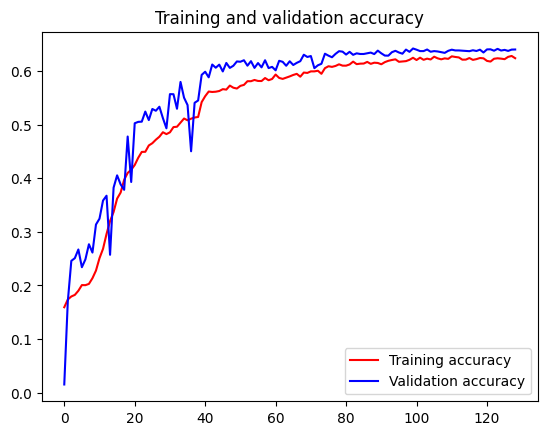

<Figure size 640x480 with 0 Axes>

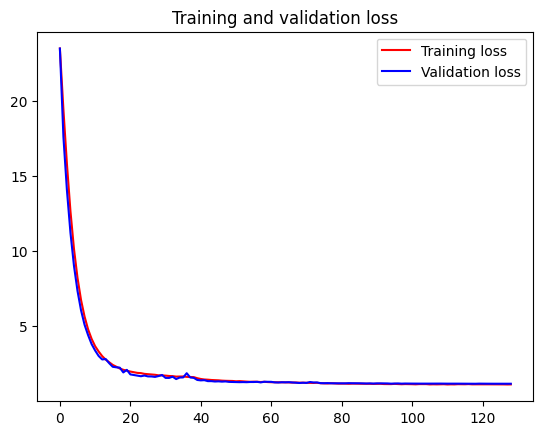

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest8_MoreData3.history['accuracy']
val_acc = historytest8_MoreData3.history['val_accuracy']
loss = historytest8_MoreData3.history['loss']
val_loss = historytest8_MoreData3.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

### Not vertical_flip 66.45%

In [27]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'fer2013/train'
test_dir = 'fer2013/test'

train_datagen4 = ImageDataGenerator(
    rescale=1/255,                
    rotation_range=20,            
    horizontal_flip=True,         
    validation_split=0.2          
)

val_datagen4 = ImageDataGenerator(
    rescale=1/255, 
    validation_split=0.2
)

test_datagen4 = ImageDataGenerator(
    rescale=1/255
)

train_generator4 = train_datagen4.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    subset="training",              
    shuffle=True
)

val_generator4 = val_datagen4.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    subset="validation",            
    shuffle=False
)

test_generator4 = test_datagen4.flow_from_directory(
    directory=test_dir,
    target_size=(img_shape, img_shape),       
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    shuffle=False
)




classes = np.array(train_generator4.classes)


class_weights = compute_class_weight(
    class_weight='balanced',  
    classes=np.unique(classes),  
    y=classes  
)


class_weights_dict = dict(enumerate(class_weights))


print("Class Weights Dictionary:", class_weights_dict)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class Weights Dictionary: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


In [ ]:
model8_MoreData4 = tf.keras.models.Sequential()   

model8_MoreData4.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,3)))
model8_MoreData4.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model8_MoreData4.add(BatchNormalization())
model8_MoreData4.add(MaxPooling2D(2, 2))
model8_MoreData4.add(Dropout(0.3))

model8_MoreData4.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData4.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData4.add(BatchNormalization())
model8_MoreData4.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData4.add(Dropout(0.3))

model8_MoreData4.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData4.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData4.add(BatchNormalization())
model8_MoreData4.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData4.add(Dropout(0.3))

model8_MoreData4.add(Flatten())
model8_MoreData4.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
model8_MoreData4.add(Dropout(0.5))
    
model8_MoreData4.add(Dense(7, activation='softmax'))

model8_MoreData4.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test8_MoreData4_otherImageGenerator4/64batch', exist_ok=True)


checkpoint_path = 'models/test8_MoreData4_otherImageGenerator4/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test8_MoreData4_otherImageGenerator4/64batch', exist_ok=True)



log_dir = "logs/test8_MoreData4_otherImageGenerator4/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [ ]:
historytest8_MoreData4 = model8_MoreData4.fit(
    x = train_generator4,
    epochs = 300,
    validation_data = val_generator4, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 23.2706 - accuracy: 0.1807
Epoch 1: val_accuracy improved from -inf to 0.25118, saving model to models/test8_MoreData4_otherImageGenerator4/64batch\best_model_ModelPaper2_1_0.2512.h5
359/359 [==============================] - 44s 117ms/step - loss: 23.2706 - accuracy: 0.1807 - val_loss: 23.4309 - val_accuracy: 0.2512 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 19.1097 - accuracy: 0.2103
Epoch 2: val_accuracy improved from 0.25118 to 0.27417, saving model to models/test8_MoreData4_otherImageGenerator4/64batch\best_model_ModelPaper2_2_0.2742.h5
359/359 [==============================] - 42s 116ms/step - loss: 19.1097 - accuracy: 0.2103 - val_loss: 17.3361 - val_accuracy: 0.2742 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 15.4929 - accuracy: 0.2334
Epoch 3: val_accuracy improved from 0.27417 to 0.29838, saving model to models/test8_

In [ ]:
model8_MoreData4.evaluate(test_generator3)

113/113 [==============================] - 13s 111ms/step - loss: 1.2324 - accuracy: 0.6659


[1.2324317693710327, 0.6659236550331116]

In [ ]:
test1model8_moredata1 = tf.keras.models.load_model(r'models\test8_MoreData4_otherImageGenerator4\64batch\best_model_ModelPaper2_120_0.6589.h5') 
eval1 = test1model8_moredata1.evaluate(test_generator3)

test1model8_moredata2 = tf.keras.models.load_model(r'models\test8_MoreData4_otherImageGenerator4\64batch\best_model_ModelPaper2_103_0.6588.h5') 
eval2 = test1model8_moredata2.evaluate(test_generator3)

test1model8_moredata3 = tf.keras.models.load_model(r'models\test8_MoreData4_otherImageGenerator4\64batch\best_model_ModelPaper2_100_0.6577.h5') 
eval3 = test1model8_moredata3.evaluate(test_generator3)

test1model8_moredata4 = tf.keras.models.load_model(r'models\test8_MoreData4_otherImageGenerator4\64batch\best_model_ModelPaper2_96_0.6563.h5') 
eval4 = test1model8_moredata4.evaluate(test_generator3)

test1model8_moredata5 = tf.keras.models.load_model(r'models\test8_MoreData4_otherImageGenerator4\64batch\best_model_ModelPaper2_81_0.6530.h5') 
eval5 = test1model8_moredata5.evaluate(test_generator3)

print(eval1)
print(eval2)
print(eval3)
print(eval4)
print(eval5)

113/113 [==============================] - 5s 41ms/step - loss: 1.2547 - accuracy: 0.6629
[1.2328540086746216, 0.6645305156707764]
[1.2369061708450317, 0.6656450033187866]
[1.2361656427383423, 0.6643912196159363]
[1.2388575077056885, 0.6639732718467712]
[1.2547389268875122, 0.6628587245941162]


In [28]:
from sklearn.metrics import classification_report, confusion_matrix

model_moreData8_load = tf.keras.models.load_model(r'models\test8_MoreData4_otherImageGenerator4\64batch\best_model_ModelPaper2_103_0.6588.h5')

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model_moreData8_load.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 4s 37ms/step
              precision    recall  f1-score   support

           0       0.58      0.60      0.59       958
           1       0.63      0.59      0.61       111
           2       0.54      0.42      0.47      1024
           3       0.88      0.85      0.86      1774
           4       0.58      0.71      0.64      1233
           5       0.56      0.51      0.53      1247
           6       0.74      0.84      0.78       831

    accuracy                           0.67      7178
   macro avg       0.64      0.64      0.64      7178
weighted avg       0.66      0.67      0.66      7178

<function confusion_matrix at 0x000001870AF1AEF0>


In [29]:
model_moreData8_load.evaluate(test_generator)

113/113 [==============================] - 5s 39ms/step - loss: 1.2369 - accuracy: 0.6656


[1.2369061708450317, 0.6656450033187866]

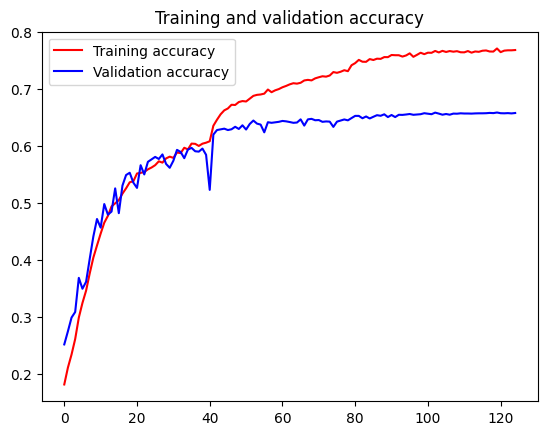

<Figure size 640x480 with 0 Axes>

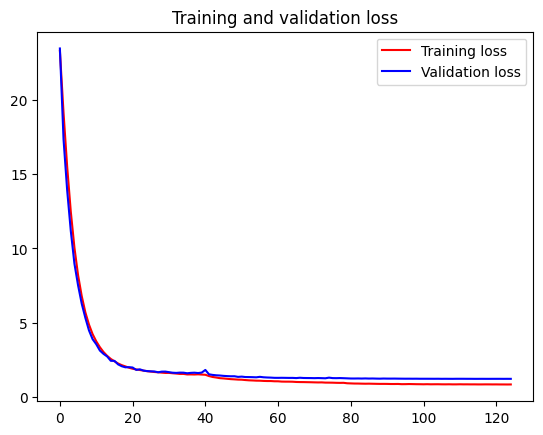

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest8_MoreData4.history['accuracy']
val_acc = historytest8_MoreData4.history['val_accuracy']
loss = historytest8_MoreData4.history['loss']
val_loss = historytest8_MoreData4.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 11 65.03%

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.regularizers import l2

model_new = Sequential()

model_new.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 3)))
model_new.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model_new.add(BatchNormalization())
model_new.add(MaxPooling2D(pool_size=(2, 2)))
model_new.add(Dropout(0.25))

model_new.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model_new.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model_new.add(BatchNormalization())
model_new.add(MaxPooling2D(pool_size=(2, 2)))
model_new.add(Dropout(0.25))

model_new.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model_new.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model_new.add(BatchNormalization())
model_new.add(MaxPooling2D(pool_size=(2, 2)))
model_new.add(Dropout(0.25))

model_new.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model_new.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model_new.add(BatchNormalization())
model_new.add(MaxPooling2D(pool_size=(2, 2)))
model_new.add(Dropout(0.25))

model_new.add(GlobalAveragePooling2D())

model_new.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model_new.add(Dropout(0.5))

model_new.add(Dense(7, activation='softmax'))

model_new.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

model_new.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 48, 48, 64)        1792      
                                                                 
 conv2d_23 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_10 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 24, 24, 128)      

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test12_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test12_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test12_MoreData/64batch', exist_ok=True)



log_dir = "logs/test12_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historymodel_new = model_new.fit(
    x = train_generator,
    epochs = 200,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/200
359/359 [==============================] - ETA: 0s - loss: 4.7836 - accuracy: 0.1647
Epoch 1: val_accuracy improved from -inf to 0.01707, saving model to models/test12_MoreData/64batch\best_model_ModelPaper2_1_0.0171.h5
359/359 [==============================] - 45s 122ms/step - loss: 4.7836 - accuracy: 0.1647 - val_loss: 4.6281 - val_accuracy: 0.0171 - lr: 1.0000e-04
Epoch 2/200
359/359 [==============================] - ETA: 0s - loss: 4.3176 - accuracy: 0.1753
Epoch 2: val_accuracy improved from 0.01707 to 0.12158, saving model to models/test12_MoreData/64batch\best_model_ModelPaper2_2_0.1216.h5
359/359 [==============================] - 43s 121ms/step - loss: 4.3176 - accuracy: 0.1753 - val_loss: 4.1467 - val_accuracy: 0.1216 - lr: 1.0000e-04
Epoch 3/200
359/359 [==============================] - ETA: 0s - loss: 3.9794 - accuracy: 0.1956
Epoch 3: val_accuracy improved from 0.12158 to 0.17819, saving model to models/test12_MoreData/64batch\best_model_ModelPaper2_3_0.1782

In [ ]:
model_new.evaluate(test_generator)

113/113 [==============================] - 10s 86ms/step - loss: 1.2812 - accuracy: 0.6503


[1.281203031539917, 0.6503204107284546]

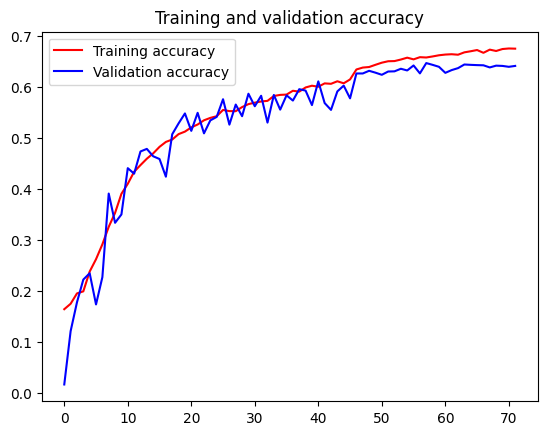

<Figure size 640x480 with 0 Axes>

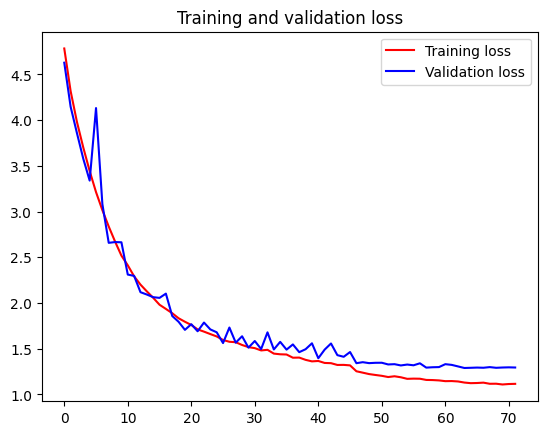

In [ ]:
import matplotlib.pyplot as plt
accuracy = historymodel_new.history['accuracy']
val_acc = historymodel_new.history['val_accuracy']
loss = historymodel_new.history['loss']
val_loss = historymodel_new.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 12 65.82%

In [ ]:
model13 = tf.keras.models.Sequential()

model13.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 3)))
model13.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model13.add(BatchNormalization())
model13.add(MaxPooling2D(2, 2))
model13.add(Dropout(0.3))

model13.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model13.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model13.add(BatchNormalization())
model13.add(MaxPooling2D(pool_size=(2, 2)))
model13.add(Dropout(0.3))

model13.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model13.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model13.add(BatchNormalization())
model13.add(MaxPooling2D(pool_size=(2, 2)))
model13.add(Dropout(0.3))

model13.add(Flatten())
model13.add(Dense(2048, activation='relu', kernel_regularizer=L2(0.01)))
model13.add(Dropout(0.5))
model13.add(Dense(1024, activation='relu', kernel_regularizer=L2(0.01)))
model13.add(Dropout(0.5))

model13.add(Dense(7, activation='softmax'))

model13.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test13_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test13_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test13_MoreData/64batch', exist_ok=True)



log_dir = "logs/test13_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historymodel_new13 = model13.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 45.4580 - accuracy: 0.1648
Epoch 1: val_accuracy improved from -inf to 0.17279, saving model to models/test13_MoreData/64batch\best_model_ModelPaper2_1_0.1728.h5
359/359 [==============================] - 47s 126ms/step - loss: 45.4580 - accuracy: 0.1648 - val_loss: 40.5393 - val_accuracy: 0.1728 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 35.8313 - accuracy: 0.1715
Epoch 2: val_accuracy improved from 0.17279 to 0.24665, saving model to models/test13_MoreData/64batch\best_model_ModelPaper2_2_0.2466.h5
359/359 [==============================] - 44s 121ms/step - loss: 35.8313 - accuracy: 0.1715 - val_loss: 31.2111 - val_accuracy: 0.2466 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 27.3132 - accuracy: 0.1892
Epoch 3: val_accuracy improved from 0.24665 to 0.26267, saving model to models/test13_MoreData/64batch\best_model_ModelPaper2_3

113/113 [==============================] - 12s 107ms/step - loss: 1.1889 - accuracy: 0.6583
[1.1888659000396729, 0.6582613587379456]


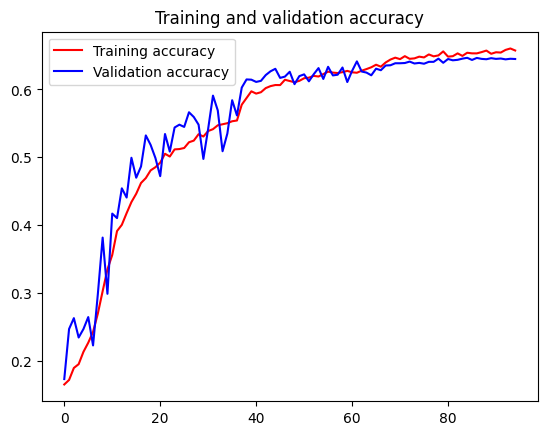

<Figure size 640x480 with 0 Axes>

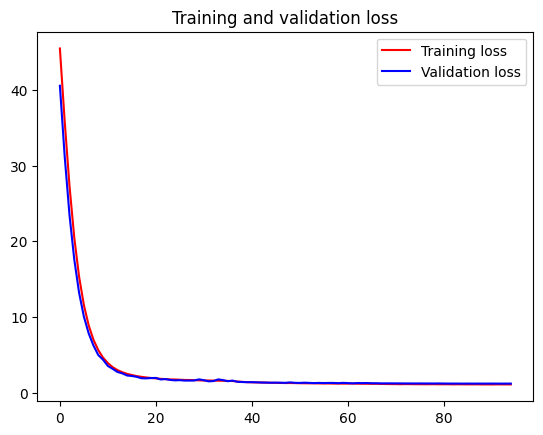

In [ ]:
print(model13.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = historymodel_new13.history['accuracy']
val_acc = historymodel_new13.history['val_accuracy']
loss = historymodel_new13.history['loss']
val_loss = historymodel_new13.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 13 63.97%

In [ ]:
model14 = tf.keras.models.Sequential()

model14.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 3)))
model14.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model14.add(BatchNormalization())
model14.add(MaxPooling2D(2, 2))
model14.add(Dropout(0.3))

model14.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model14.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model14.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model14.add(BatchNormalization())
model14.add(MaxPooling2D(pool_size=(2, 2)))
model14.add(Dropout(0.3))

model14.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model14.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model14.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model14.add(BatchNormalization())
model14.add(MaxPooling2D(pool_size=(2, 2)))
model14.add(Dropout(0.3))

model14.add(Flatten())
model14.add(Dense(1024, activation='relu', kernel_regularizer=L2(0.01)))
model14.add(Dropout(0.5))

model14.add(Dense(7, activation='softmax'))

model14.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test14_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test14_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test14_MoreData/64batch', exist_ok=True)



log_dir = "logs/test14_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historymodel_new14 = model14.fit(
    x = train_generator,
    epochs = 200,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/200
359/359 [==============================] - ETA: 0s - loss: 25.5448 - accuracy: 0.1695
Epoch 1: val_accuracy improved from -inf to 0.17453, saving model to models/test14_MoreData/64batch\best_model_ModelPaper2_1_0.1745.h5
359/359 [==============================] - 46s 124ms/step - loss: 25.5448 - accuracy: 0.1695 - val_loss: 23.5219 - val_accuracy: 0.1745 - lr: 1.0000e-04
Epoch 2/200
359/359 [==============================] - ETA: 0s - loss: 20.9644 - accuracy: 0.1817
Epoch 2: val_accuracy improved from 0.17453 to 0.22818, saving model to models/test14_MoreData/64batch\best_model_ModelPaper2_2_0.2282.h5
359/359 [==============================] - 44s 123ms/step - loss: 20.9644 - accuracy: 0.1817 - val_loss: 18.8783 - val_accuracy: 0.2282 - lr: 1.0000e-04
Epoch 3/200
359/359 [==============================] - ETA: 0s - loss: 17.0672 - accuracy: 0.1937
Epoch 3: val_accuracy did not improve from 0.22818
359/359 [==============================] - 44s 123ms/step - loss: 17.0672 - 

113/113 [==============================] - 5s 42ms/step - loss: 1.2383 - accuracy: 0.6397
[1.238294005393982, 0.6397325396537781]


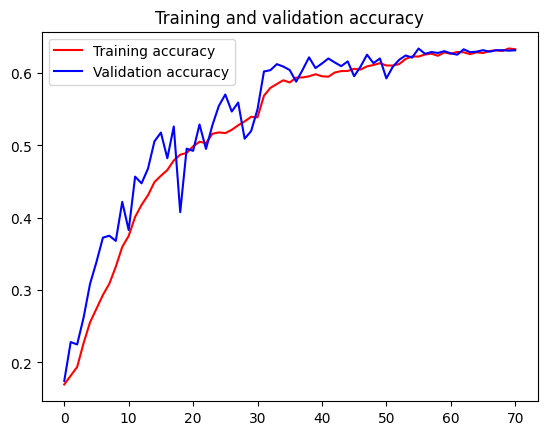

<Figure size 640x480 with 0 Axes>

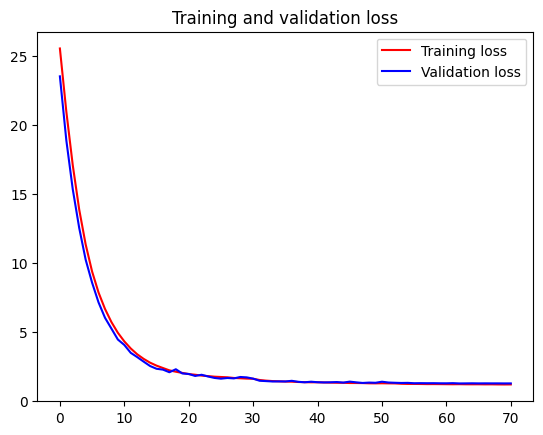

In [ ]:
print(model14.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = historymodel_new14.history['accuracy']
val_acc = historymodel_new14.history['val_accuracy']
loss = historymodel_new14.history['loss']
val_loss = historymodel_new14.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 14 64.14%

In [ ]:
model15 = Sequential()

model15.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 3)))
model15.add(BatchNormalization())
model15.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(MaxPooling2D(pool_size=(2, 2)))
model15.add(Dropout(0.3))

model15.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(MaxPooling2D(pool_size=(2, 2)))
model15.add(Dropout(0.3))

model15.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(MaxPooling2D(pool_size=(2, 2)))
model15.add(Dropout(0.3))

model15.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model15.add(BatchNormalization())
model15.add(MaxPooling2D(pool_size=(2, 2)))
model15.add(Dropout(0.3))

model15.add(Flatten())
model15.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.01)))
model15.add(Dropout(0.5))
model15.add(Dense(7, activation='softmax'))

model15.compile(optimizer=Adam(learning_rate=1e-4), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

model15.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_14 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_31 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_15 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                      

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test15_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test15_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test15_MoreData/64batch', exist_ok=True)



log_dir = "logs/test15_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historymodel_new15 = model15.fit(
    x = train_generator,
    epochs = 200,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/200
359/359 [==============================] - ETA: 0s - loss: 17.5825 - accuracy: 0.1654
Epoch 1: val_accuracy improved from -inf to 0.18464, saving model to models/test15_MoreData/64batch\best_model_ModelPaper2_1_0.1846.h5
359/359 [==============================] - 59s 143ms/step - loss: 17.5825 - accuracy: 0.1654 - val_loss: 15.3793 - val_accuracy: 0.1846 - lr: 1.0000e-04
Epoch 2/200
359/359 [==============================] - ETA: 0s - loss: 13.4096 - accuracy: 0.1803
Epoch 2: val_accuracy improved from 0.18464 to 0.24090, saving model to models/test15_MoreData/64batch\best_model_ModelPaper2_2_0.2409.h5
359/359 [==============================] - 49s 136ms/step - loss: 13.4096 - accuracy: 0.1803 - val_loss: 11.6079 - val_accuracy: 0.2409 - lr: 1.0000e-04
Epoch 3/200
359/359 [==============================] - ETA: 0s - loss: 9.9643 - accuracy: 0.1938
Epoch 3: val_accuracy did not improve from 0.24090
359/359 [==============================] - 49s 135ms/step - loss: 9.9643 - ac

113/113 [==============================] - 8s 72ms/step - loss: 1.0261 - accuracy: 0.6414
[1.0261285305023193, 0.6414042711257935]


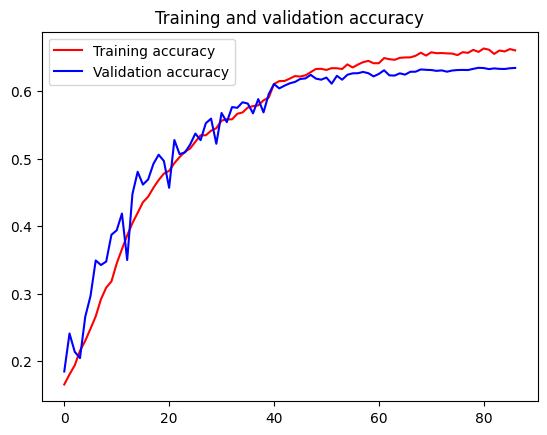

<Figure size 640x480 with 0 Axes>

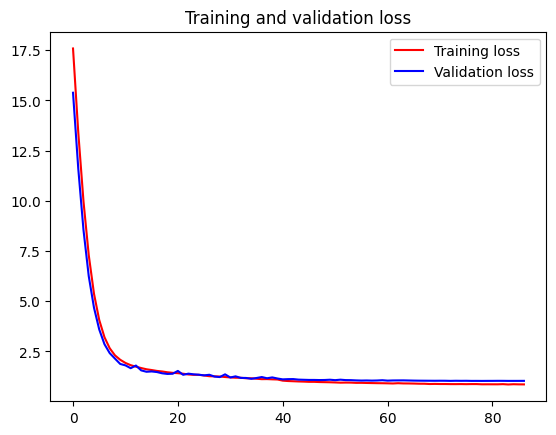

In [ ]:
print(model15.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = historymodel_new15.history['accuracy']
val_acc = historymodel_new15.history['val_accuracy']
loss = historymodel_new15.history['loss']
val_loss = historymodel_new15.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 15 51.75%

In [ ]:
from keras.layers import concatenate

def inception_module(x, filters):
    path1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)

    path2 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    path2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(path2)

    path3 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    path3 = Conv2D(filters, (5, 5), padding='same', activation='relu')(path3)

    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = Conv2D(filters, (1, 1), padding='same', activation='relu')(path4)

    return concatenate([path1, path2, path3, path4], axis=-1)

input_layer = Input(shape=(48, 48, 3))
x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = inception_module(x, 32)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = inception_module(x, 64)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = inception_module(x, 128)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Flatten()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output_layer = Dense(7, activation='softmax')(x)

model16 = Model(inputs=input_layer, outputs=output_layer)

model16.compile(optimizer=Adam(learning_rate=1e-4), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

model16.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d_38 (Conv2D)             (None, 48, 48, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization_22 (BatchN  (None, 48, 48, 64)  256         ['conv2d_38[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_18 (MaxPooling2D  (None, 24, 24, 64)  0           ['batch_normalization_22[0][0

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test16_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test16_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test16_MoreData/64batch', exist_ok=True)



log_dir = "logs/test16_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historymodel_new16 = model16.fit(
    x = train_generator,
    epochs = 200,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)


Epoch 1/200
359/359 [==============================] - ETA: 0s - loss: 14.1743 - accuracy: 0.1576
Epoch 1: val_accuracy improved from -inf to 0.21704, saving model to models/test16_MoreData/64batch\best_model_ModelPaper2_1_0.2170.h5
359/359 [==============================] - 45s 120ms/step - loss: 14.1743 - accuracy: 0.1576 - val_loss: 10.5153 - val_accuracy: 0.2170 - lr: 1.0000e-04
Epoch 2/200
359/359 [==============================] - ETA: 0s - loss: 8.5047 - accuracy: 0.1724
Epoch 2: val_accuracy did not improve from 0.21704
359/359 [==============================] - 42s 117ms/step - loss: 8.5047 - accuracy: 0.1724 - val_loss: 6.8673 - val_accuracy: 0.1482 - lr: 1.0000e-04
Epoch 3/200
359/359 [==============================] - ETA: 0s - loss: 5.7520 - accuracy: 0.1771
Epoch 3: val_accuracy improved from 0.21704 to 0.23515, saving model to models/test16_MoreData/64batch\best_model_ModelPaper2_3_0.2352.h5
359/359 [==============================] - 42s 118ms/step - loss: 5.7520 - accur

113/113 [==============================] - 5s 41ms/step - loss: 1.3449 - accuracy: 0.5176
[1.3448723554611206, 0.5175536274909973]


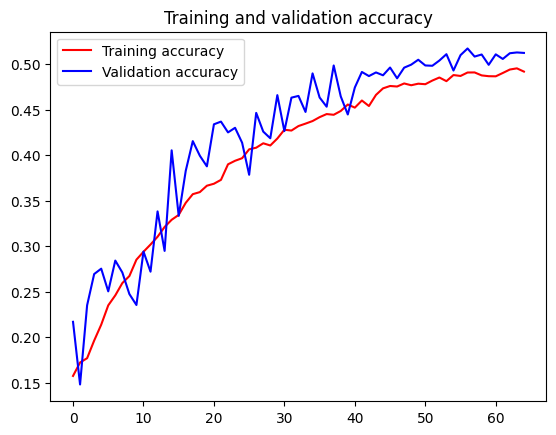

<Figure size 640x480 with 0 Axes>

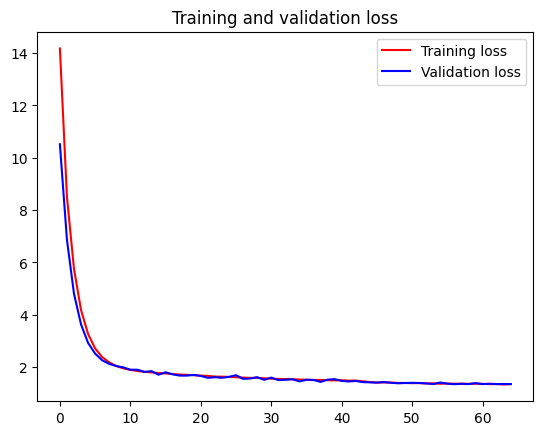

In [ ]:
print(model16.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = historymodel_new16.history['accuracy']
val_acc = historymodel_new16.history['val_accuracy']
loss = historymodel_new16.history['loss']
val_loss = historymodel_new16.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 16 - MiniXceptionNet 24.81%

In [ ]:
from keras import layers
from keras.layers import Activation, Convolution2D, Conv2D, Dropout, AveragePooling2D, BatchNormalization, GlobalAveragePooling2D, Flatten, Input, MaxPooling2D, SeparableConv2D
from keras.models import Model
from keras.regularizers import L2

l2_regularization = 0.01
regularization = L2(l2_regularization)


image_input = Input((48,48,3))


x = Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), kernel_regularizer=regularization, use_bias=False)(image_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x= Dropout(0.25)(x)


residual = Conv2D(filters=16, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x= Dropout(0.25)(x)


x = SeparableConv2D(filters=16, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=16, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])
x= Dropout(0.25)(x)


residual = Conv2D(filters=32, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x= Dropout(0.25)(x)

x = SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])
x= Dropout(0.25)(x)

residual = Conv2D(filters=64, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x= Dropout(0.25)(x)

x = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])
x= Dropout(0.25)(x)

residual = Conv2D(filters=128, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x= Dropout(0.25)(x)

x = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])
x= Dropout(0.25)(x)

x = Conv2D(filters=7, kernel_size=(3,3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
x= Dropout(0.5)(x)

output = Activation('softmax', name='predictions')(x)


modelMini = Model(image_input, output)
modelMini.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
modelMini.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d_57 (Conv2D)             (None, 46, 46, 8)    216         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_23 (BatchN  (None, 46, 46, 8)   32          ['conv2d_57[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation (Activation)        (None, 46, 46, 8)    0           ['batch_normalization_23[0]

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test17_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test17_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test17_MoreData/64batch', exist_ok=True)



log_dir = "logs/test17_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historymodel_new17 = modelMini.fit(
    x = train_generator,
    epochs = 200,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/200
359/359 [==============================] - ETA: 0s - loss: 2.2996 - accuracy: 0.1425
Epoch 1: val_accuracy improved from -inf to 0.25187, saving model to models/test17_MoreData/64batch\best_model_ModelPaper2_1_0.2519.h5
359/359 [==============================] - 42s 109ms/step - loss: 2.2996 - accuracy: 0.1425 - val_loss: 1.9998 - val_accuracy: 0.2519 - lr: 1.0000e-04
Epoch 2/200
359/359 [==============================] - ETA: 0s - loss: 2.2168 - accuracy: 0.1479
Epoch 2: val_accuracy did not improve from 0.25187
359/359 [==============================] - 37s 103ms/step - loss: 2.2168 - accuracy: 0.1479 - val_loss: 2.1371 - val_accuracy: 0.0667 - lr: 1.0000e-04
Epoch 3/200
359/359 [==============================] - ETA: 0s - loss: 2.2003 - accuracy: 0.1480
Epoch 3: val_accuracy did not improve from 0.25187
359/359 [==============================] - 37s 104ms/step - loss: 2.2003 - accuracy: 0.1480 - val_loss: 2.1143 - val_accuracy: 0.0549 - lr: 1.0000e-04
Epoch 4/200
359/359

113/113 [==============================] - 5s 43ms/step - loss: 2.0028 - accuracy: 0.2481
[2.0028414726257324, 0.24811924993991852]


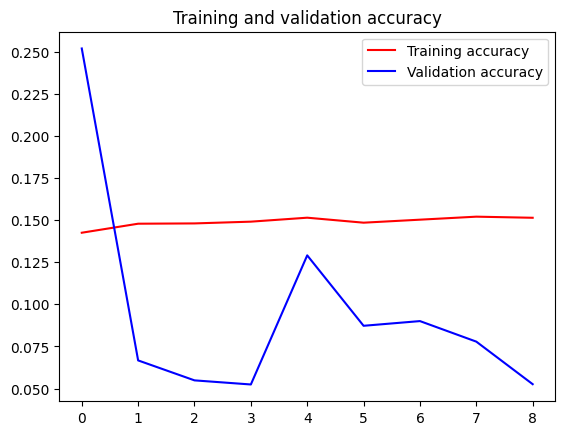

<Figure size 640x480 with 0 Axes>

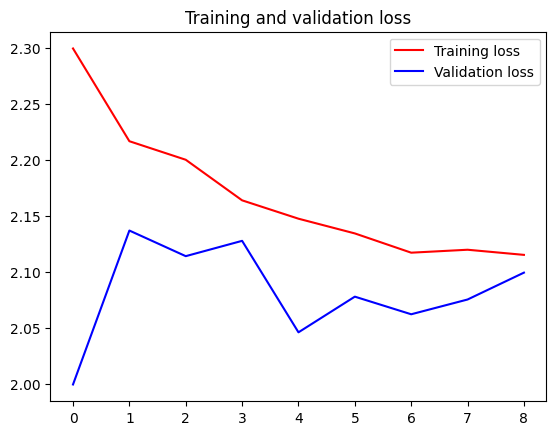

In [ ]:
print(modelMini.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = historymodel_new17.history['accuracy']
val_acc = historymodel_new17.history['val_accuracy']
loss = historymodel_new17.history['loss']
val_loss = historymodel_new17.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 17 60.04%

In [ ]:
from keras.applications import Xception
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D, Resizing, Input
from tensorflow.keras.optimizers import Adam
from keras.regularizers import L2 


base_modelXception = Xception(weights= "imagenet", input_shape=(75,75,3), include_top=False)

for layer in base_modelXception.layers[:-10]:
  layer.trainable = False

input= Input(shape=(48,48,3))
input_resize = Resizing(75,75)(input) #Debido que XceptionNet necesita entrada con tamaño 75x75 se redimensiona

x = base_modelXception(input_resize)
x = Dropout(0.50)(x)
x = BatchNormalization()(x)
x = Dropout(0.50)(x)
x = GlobalAveragePooling2D()(x)

x = Dense(2048, activation='relu', kernel_regularizer=L2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation="softmax")(x)

modelXception = Model(inputs = input, outputs = predictions)

modelXception.compile(loss="categorical_crossentropy", optimizer=Adam(1e-4), metrics=["accuracy"])

modelXception.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 75, 75, 3)         0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 dropout_39 (Dropout)        (None, 3, 3, 2048)        0         
                                                                 
 batch_normalization_41 (Bat  (None, 3, 3, 2048)       8192      
 chNormalization)                                                
                                                                 
 dropout_40 (Dropout)        (None, 3, 3, 2048)        0         
                                                           

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test18_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test18_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test18_MoreData/64batch', exist_ok=True)



log_dir = "logs/test18_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historymodel_new18 = modelXception.fit(
    x = train_generator,
    epochs = 200,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/200
359/359 [==============================] - ETA: 0s - loss: 3.8699 - accuracy: 0.2684
Epoch 1: val_accuracy improved from -inf to 0.41125, saving model to models/test18_MoreData/64batch\best_model_ModelPaper2_1_0.4113.h5
359/359 [==============================] - 56s 140ms/step - loss: 3.8699 - accuracy: 0.2684 - val_loss: 3.5143 - val_accuracy: 0.4113 - lr: 1.0000e-04
Epoch 2/200
359/359 [==============================] - ETA: 0s - loss: 3.5495 - accuracy: 0.3514
Epoch 2: val_accuracy improved from 0.41125 to 0.44226, saving model to models/test18_MoreData/64batch\best_model_ModelPaper2_2_0.4423.h5
359/359 [==============================] - 47s 131ms/step - loss: 3.5495 - accuracy: 0.3514 - val_loss: 3.3121 - val_accuracy: 0.4423 - lr: 1.0000e-04
Epoch 3/200
359/359 [==============================] - ETA: 0s - loss: 3.3347 - accuracy: 0.3878
Epoch 3: val_accuracy improved from 0.44226 to 0.45706, saving model to models/test18_MoreData/64batch\best_model_ModelPaper2_3_0.4571

113/113 [==============================] - 9s 81ms/step - loss: 1.3546 - accuracy: 0.6004
[1.3546204566955566, 0.6004458069801331]


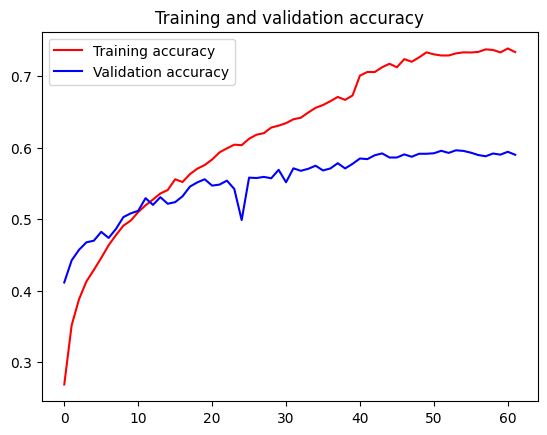

<Figure size 640x480 with 0 Axes>

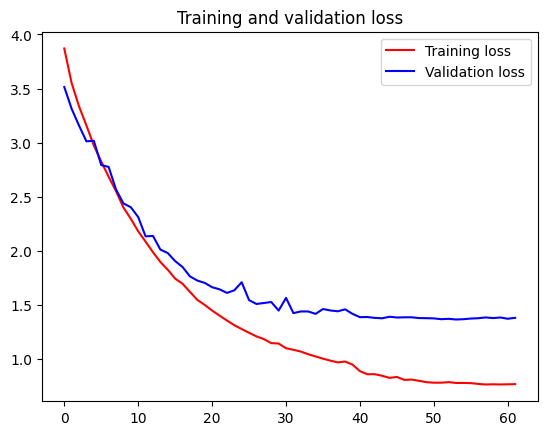

In [ ]:
print(modelXception.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = historymodel_new18.history['accuracy']
val_acc = historymodel_new18.history['val_accuracy']
loss = historymodel_new18.history['loss']
val_loss = historymodel_new18.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 18 52.07%

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2

model20 = Sequential()

model20.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 3)))
model20.add(BatchNormalization())
model20.add(MaxPooling2D(pool_size=(2, 2)))
model20.add(Dropout(0.25))

model20.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model20.add(BatchNormalization())
model20.add(MaxPooling2D(pool_size=(2, 2)))
model20.add(Dropout(0.25))

model20.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model20.add(BatchNormalization())
model20.add(MaxPooling2D(pool_size=(2, 2)))
model20.add(Dropout(0.25))

model20.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model20.add(BatchNormalization())
model20.add(MaxPooling2D(pool_size=(2, 2)))
model20.add(Dropout(0.25))

model20.add(Flatten())
model20.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model20.add(Dropout(0.5))
model20.add(Dense(7, activation='softmax'))

model20.compile(optimizer=Adam(learning_rate=1e-4), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

model20.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_73 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_47 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 dropout_44 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_74 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_48 (Bat  (None, 24, 24, 64)      

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test20_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test20_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test20_MoreData/64batch', exist_ok=True)



log_dir = "logs/test20_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historymodel_new20 = model20.fit(
    x = train_generator,
    epochs = 200,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/200
359/359 [==============================] - ETA: 0s - loss: 10.2926 - accuracy: 0.1602
Epoch 1: val_accuracy improved from -inf to 0.05905, saving model to models/test20_MoreData/64batch\best_model_ModelPaper2_1_0.0590.h5
359/359 [==============================] - 62s 168ms/step - loss: 10.2926 - accuracy: 0.1602 - val_loss: 10.0446 - val_accuracy: 0.0590 - lr: 1.0000e-04
Epoch 2/200
359/359 [==============================] - ETA: 0s - loss: 8.5992 - accuracy: 0.1796
Epoch 2: val_accuracy improved from 0.05905 to 0.14196, saving model to models/test20_MoreData/64batch\best_model_ModelPaper2_2_0.1420.h5
359/359 [==============================] - 41s 113ms/step - loss: 8.5992 - accuracy: 0.1796 - val_loss: 8.0520 - val_accuracy: 0.1420 - lr: 1.0000e-04
Epoch 3/200
359/359 [==============================] - ETA: 0s - loss: 7.2472 - accuracy: 0.1887
Epoch 3: val_accuracy improved from 0.14196 to 0.18499, saving model to models/test20_MoreData/64batch\best_model_ModelPaper2_3_0.1

113/113 [==============================] - 10s 85ms/step - loss: 1.3177 - accuracy: 0.5208
[1.3177154064178467, 0.5207578539848328]


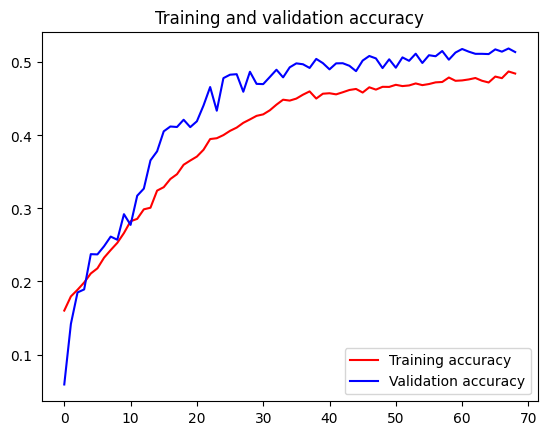

<Figure size 640x480 with 0 Axes>

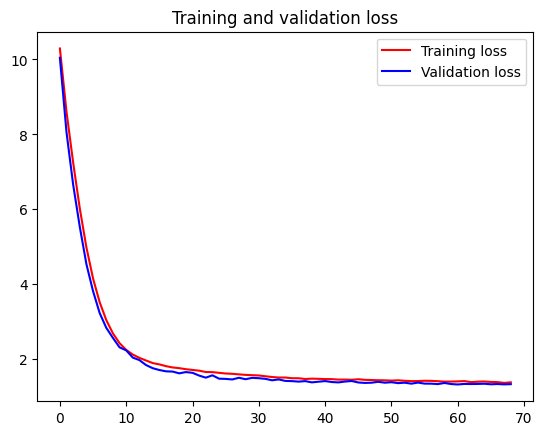

In [ ]:
print(model20.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = historymodel_new20.history['accuracy']
val_acc = historymodel_new20.history['val_accuracy']
loss = historymodel_new20.history['loss']
val_loss = historymodel_new20.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 19 60.32%

In [ ]:
from keras.applications import MobileNet

MobileNet = tf.keras.applications.MobileNet(input_shape=(48, 48, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

MobileNet.summary()

MobileNet.trainable = True

for layer in MobileNet.layers[:-50]:
    layer.trainable = False

def Create_MobileNet_Model():

    model = Sequential([
                      MobileNet,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])
    return model

MobileNet_Model = Create_MobileNet_Model()

MobileNet_Model.summary()

MobileNet_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 24, 24, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 24, 24, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 24, 24, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 24, 24, 32)       128       
 ation)                                         

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test21_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test21_MoreData/64batch/best_model_ModelPaper2_{epoch}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test21_MoreData/64batch', exist_ok=True)



log_dir = "logs/test21_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = val_generator.n // val_generator.batch_size

In [47]:
historymodel_new21 = MobileNet_Model.fit(
    x = train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs = 200,
    validation_data = val_generator, 
    validation_steps=validation_steps,
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/200
358/358 [==============================] - ETA: 0s - loss: 2.2484 - accuracy: 0.2225
Epoch 1: val_accuracy improved from -inf to 0.34077, saving model to models/test21_MoreData/64batch\best_model_ModelPaper2_1.h5
358/358 [==============================] - 43s 114ms/step - loss: 2.2484 - accuracy: 0.2225 - val_loss: 1.7282 - val_accuracy: 0.3408 - lr: 0.0010
Epoch 2/200
358/358 [==============================] - ETA: 0s - loss: 1.7481 - accuracy: 0.3369
Epoch 2: val_accuracy improved from 0.34077 to 0.38869, saving model to models/test21_MoreData/64batch\best_model_ModelPaper2_2.h5
358/358 [==============================] - 40s 111ms/step - loss: 1.7481 - accuracy: 0.3369 - val_loss: 1.5811 - val_accuracy: 0.3887 - lr: 0.0010
Epoch 3/200
358/358 [==============================] - ETA: 0s - loss: 1.5912 - accuracy: 0.3847
Epoch 3: val_accuracy improved from 0.38869 to 0.41854, saving model to models/test21_MoreData/64batch\best_model_ModelPaper2_3.h5
358/358 [================

113/113 [==============================] - 9s 78ms/step - loss: 1.0977 - accuracy: 0.6032
[1.0977210998535156, 0.6032320857048035]


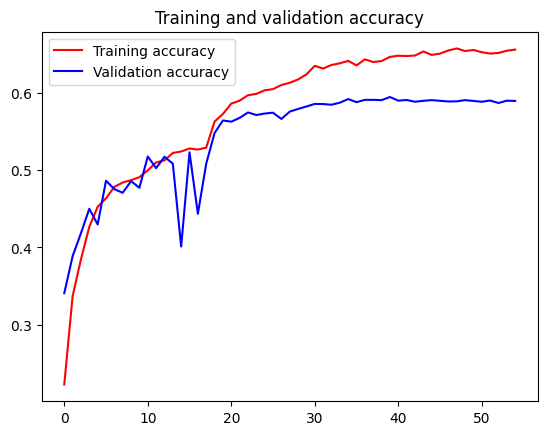

<Figure size 640x480 with 0 Axes>

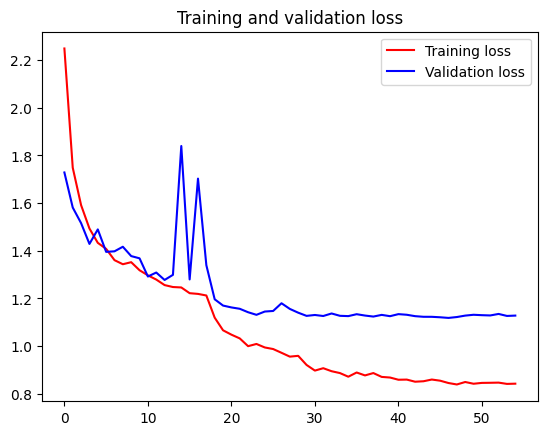

In [48]:
print(MobileNet_Model.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = historymodel_new21.history['accuracy']
val_acc = historymodel_new21.history['val_accuracy']
loss = historymodel_new21.history['loss']
val_loss = historymodel_new21.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 20 57.41%

In [64]:
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
import tensorflow as tf 

model22 = Sequential()

model22.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,3)))
model22.add(BatchNormalization())
model22.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model22.add(BatchNormalization())
model22.add(MaxPooling2D(pool_size=(2, 2)))
model22.add(Dropout(0.25))

model22.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model22.add(BatchNormalization())
model22.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model22.add(BatchNormalization())
model22.add(MaxPooling2D(pool_size=(2, 2)))
model22.add(Dropout(0.25))

model22.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model22.add(BatchNormalization())
model22.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model22.add(BatchNormalization())
model22.add(MaxPooling2D(pool_size=(2, 2)))
model22.add(Dropout(0.25))

model22.add(Flatten())
model22.add(Dense(256, activation='relu'))
model22.add(BatchNormalization())
model22.add(Dropout(0.5))
model22.add(Dense(128, activation='relu')) # thapeko
model22.add(Dense(7, activation='softmax'))

model22.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(lr=0.01), metrics=['accuracy'])

c:\Users\bryan\anaconda3\envs\GPU_IEMOCAP\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [65]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test22_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test22_MoreData/64batch/best_model_ModelPaper2_{epoch}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test22_MoreData/64batch', exist_ok=True)



log_dir = "logs/test22_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [66]:
historymodel_new22 = model22.fit(
    x = train_generator,
    steps_per_epoch=len(train_generator),
    epochs = 200,
    validation_data = val_generator, 
    validation_steps=len(val_generator),
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/200
359/359 [==============================] - ETA: 0s - loss: 2.0908 - accuracy: 0.1533
Epoch 1: val_accuracy improved from -inf to 0.15154, saving model to models/test22_MoreData/64batch\best_model_ModelPaper2_1.h5
359/359 [==============================] - 48s 126ms/step - loss: 2.0908 - accuracy: 0.1533 - val_loss: 1.9694 - val_accuracy: 0.1515 - lr: 0.0100
Epoch 2/200
359/359 [==============================] - ETA: 0s - loss: 1.9321 - accuracy: 0.1686
Epoch 2: val_accuracy improved from 0.15154 to 0.17662, saving model to models/test22_MoreData/64batch\best_model_ModelPaper2_2.h5
359/359 [==============================] - 41s 114ms/step - loss: 1.9321 - accuracy: 0.1686 - val_loss: 1.9189 - val_accuracy: 0.1766 - lr: 0.0100
Epoch 3/200
359/359 [==============================] - ETA: 0s - loss: 1.8998 - accuracy: 0.1931
Epoch 3: val_accuracy improved from 0.17662 to 0.19962, saving model to models/test22_MoreData/64batch\best_model_ModelPaper2_3.h5
359/359 [================

113/113 [==============================] - 12s 103ms/step - loss: 1.1227 - accuracy: 0.5741
[1.122687816619873, 0.5741153359413147]


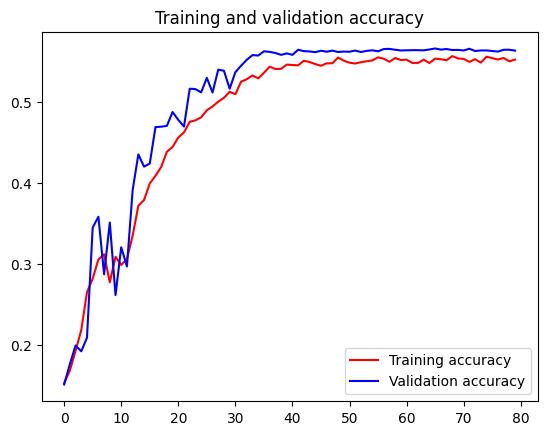

<Figure size 640x480 with 0 Axes>

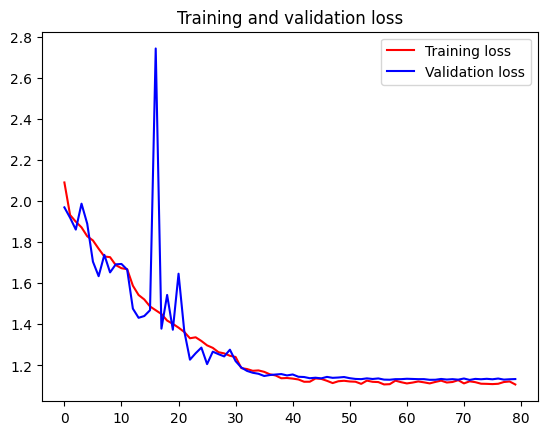

In [67]:
print(model22.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = historymodel_new22.history['accuracy']
val_acc = historymodel_new22.history['val_accuracy']
loss = historymodel_new22.history['loss']
val_loss = historymodel_new22.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 21 Keras Tunner

In [46]:
def build_model(hp):
    input_layer = tf.keras.layers.Input(shape=(48, 48, 3))
    x = input_layer
    
    num_layers = hp.Int('num_layers', min_value=2, max_value=6)
    for i in range(num_layers):
        num_filters1 = hp.Int(f'conv_{i}_units1', min_value=32, max_value=512, step=32)
        x = tf.keras.layers.Conv2D(filters=num_filters1, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x)
        num_filters2 = hp.Int(f'conv_{i}_units2', min_value=32, max_value=512, step=32)
        x = tf.keras.layers.Conv2D(filters=num_filters2, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=L2(0.01))(x)
        x = BatchNormalization()(x)
        
        # Verificación condicional para MaxPooling2D
        if x.shape[1] > 1 and x.shape[2] > 1:
            x = MaxPooling2D(pool_size=(2, 2))(x)
        
        x = Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1))(x)

    x = tf.keras.layers.Flatten()(x)
    x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(7, activation="softmax")(x)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=Adam(1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model



In [47]:
import keras_tuner as kt


In [48]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=6,  # Número máximo de pruebas.
    executions_per_trial=3,
    directory='TunerBayesianDirectory',
    project_name='KerasTuner'
)

In [49]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test8_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test8_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test8_MoreData/64batch', exist_ok=True)



log_dir = "logs/test8_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [50]:
tuner.search(
    x=train_generator,
    epochs=300,  
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback, reduce_lr],
    shuffle=True
)

Trial 6 Complete [03h 47m 13s]
val_accuracy: 0.6558090845743815

Best val_accuracy So Far: 0.6612669229507446
Total elapsed time: 18h 11m 53s


In [51]:
print(tuner.get_best_models()[0].summary())
print(tuner.get_best_hyperparameters()[0].values)

model = tuner.get_best_models(num_models=1)[0]
print (model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 288)       166176    
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 288)      1152      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 288)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 288)       0     

In [11]:
input = tf.keras.layers.Input(shape=(48,48,3))
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(input)
x = Conv2D(288, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.2)(x)

x = Conv2D(160, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = Conv2D(160, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.4)(x)

x = Conv2D(288, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.2)(x)

x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = Conv2D(224, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.4)(x)

#x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
#x = Conv2D(160, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
#x = BatchNormalization()(x)
#x = MaxPooling2D(2,2)(x)
#x = Dropout(0.4)(x)


x = tf.keras.layers.Flatten()(x)
x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
x = Dropout(0.5)(x)
output_layer = Dense(7, activation="softmax")(x)

modelTunner = tf.keras.models.Model(inputs=input, outputs=output_layer)

modelTunner.compile(optimizer=Adam(1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

modelTunner.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 48, 48, 64)        1792      
                                                                 
 conv2d_41 (Conv2D)          (None, 48, 48, 288)       166176    
                                                                 
 batch_normalization_20 (Bat  (None, 48, 48, 288)      1152      
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 24, 24, 288)      0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 24, 24, 288)       0   

In [12]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/ModelKerasTunner/64batch', exist_ok=True)


checkpoint_path = 'models/ModelKerasTunner/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/ModelKerasTunner/64batch', exist_ok=True)



log_dir = "logs/ModelKerasTunner/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

In [13]:
HistoryTunner = modelTunner.fit(
    x=train_generator,
    epochs=300,  
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback, reduce_lr],
    shuffle=True
)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 27.0807 - accuracy: 0.1572
Epoch 1: val_accuracy improved from -inf to 0.18742, saving model to models/ModelKerasTunner/64batch\best_model_ModelPaper2_1_0.1874.h5
359/359 [==============================] - 85s 210ms/step - loss: 27.0807 - accuracy: 0.1572 - val_loss: 25.1658 - val_accuracy: 0.1874 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 23.3976 - accuracy: 0.1684
Epoch 2: val_accuracy improved from 0.18742 to 0.19753, saving model to models/ModelKerasTunner/64batch\best_model_ModelPaper2_2_0.1975.h5
359/359 [==============================] - 58s 161ms/step - loss: 23.3976 - accuracy: 0.1684 - val_loss: 22.1033 - val_accuracy: 0.1975 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 20.2524 - accuracy: 0.1761
Epoch 3: val_accuracy improved from 0.19753 to 0.24909, saving model to models/ModelKerasTunner/64batch\best_model_ModelPaper

113/113 [==============================] - 26s 228ms/step - loss: 1.1732 - accuracy: 0.6694
[1.173243761062622, 0.669406533241272]


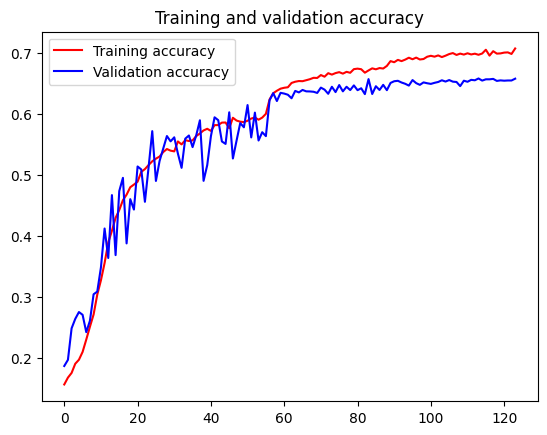

<Figure size 640x480 with 0 Axes>

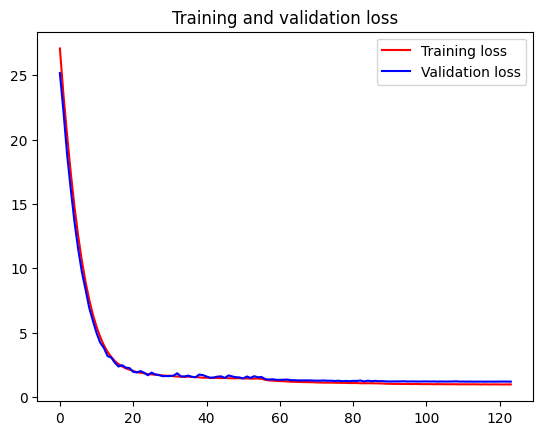

In [14]:
print(modelTunner.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = HistoryTunner.history['accuracy']
val_acc = HistoryTunner.history['val_accuracy']
loss = HistoryTunner.history['loss']
val_loss = HistoryTunner.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

In [15]:
input = tf.keras.layers.Input(shape=(48,48,3))
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(input)
x = Conv2D(288, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.2)(x)

x = Conv2D(160, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = Conv2D(160, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.4)(x)

x = Conv2D(288, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.2)(x)

x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = Conv2D(224, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.4)(x)

x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = Conv2D(160, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.4)(x)


x = tf.keras.layers.Flatten()(x)
x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
x = Dropout(0.5)(x)
output_layer = Dense(7, activation="softmax")(x)

modelTunner2 = tf.keras.models.Model(inputs=input, outputs=output_layer)

modelTunner2.compile(optimizer=Adam(1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

modelTunner2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 48, 48, 64)        1792      
                                                                 
 conv2d_49 (Conv2D)          (None, 48, 48, 288)       166176    
                                                                 
 batch_normalization_24 (Bat  (None, 48, 48, 288)      1152      
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 24, 24, 288)      0         
 g2D)                                                            
                                                                 
 dropout_29 (Dropout)        (None, 24, 24, 288)       0   

In [16]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/ModelKerasTunner2/64batch', exist_ok=True)


checkpoint_path = 'models/ModelKerasTunner2/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/ModelKerasTunner2/64batch', exist_ok=True)



log_dir = "logs/ModelKerasTunner2/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [17]:
HistoryTunner2 = modelTunner2.fit(
    x=train_generator,
    epochs=300,  
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback, reduce_lr],
    shuffle=True
)

Epoch 1/300
359/359 [==============================] - ETA: 0s - loss: 17.5461 - accuracy: 0.1562
Epoch 1: val_accuracy improved from -inf to 0.23306, saving model to models/ModelKerasTunner2/64batch\best_model_ModelPaper2_1_0.2331.h5
359/359 [==============================] - 62s 167ms/step - loss: 17.5461 - accuracy: 0.1562 - val_loss: 16.4878 - val_accuracy: 0.2331 - lr: 1.0000e-04
Epoch 2/300
359/359 [==============================] - ETA: 0s - loss: 15.7284 - accuracy: 0.1609
Epoch 2: val_accuracy did not improve from 0.23306
359/359 [==============================] - 59s 165ms/step - loss: 15.7284 - accuracy: 0.1609 - val_loss: 14.8925 - val_accuracy: 0.0406 - lr: 1.0000e-04
Epoch 3/300
359/359 [==============================] - ETA: 0s - loss: 14.0736 - accuracy: 0.1701
Epoch 3: val_accuracy did not improve from 0.23306
359/359 [==============================] - 58s 162ms/step - loss: 14.0736 - accuracy: 0.1701 - val_loss: 13.2442 - val_accuracy: 0.1980 - lr: 1.0000e-04
Epoch 4/

113/113 [==============================] - 5s 47ms/step - loss: 1.2093 - accuracy: 0.6585
[1.2093474864959717, 0.6585400104522705]


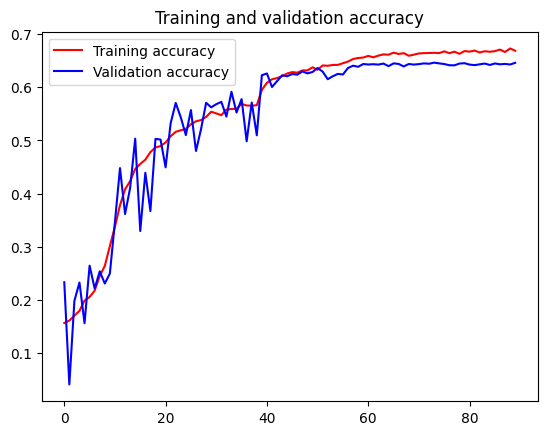

<Figure size 640x480 with 0 Axes>

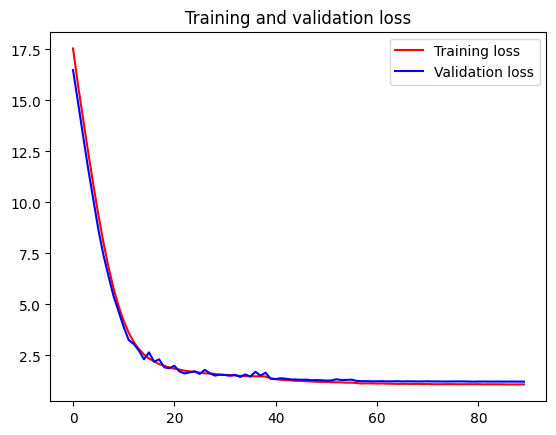

In [18]:
print(modelTunner2.evaluate(test_generator))

import matplotlib.pyplot as plt
accuracy = HistoryTunner2.history['accuracy']
val_acc = HistoryTunner2.history['val_accuracy']
loss = HistoryTunner2.history['loss']
val_loss = HistoryTunner2.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

# With 2 datasets (FER2013 and CK+48)

In [ ]:
train_dir_FER2013 = 'fer2013/train'
dataset_CK48 = 'CK+48/CK+48'

## Moving the images of FER2013 and CK+48 to concatenatedFERandCK

In [ ]:
os.makedirs('concatenatedFERandCK', exist_ok=True)

labelscorrects = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise", "anger", "sadness"]

listFilesFER = os.listdir(train_dir_FER2013)
for label in tqdm(listFilesFER):
    print("Label FER2013: ", label)
    pathlabel = os.path.join(train_dir_FER2013, label)
    listlabels = os.listdir(pathlabel)
    direction = os.path.join('concatenatedFERandCK', label)
    os.makedirs(direction, exist_ok=True)
    for fileinlabel in listlabels:
        filepath = os.path.join(pathlabel,fileinlabel)
        shutil.copy(filepath, direction)

listFilesCK = os.listdir(dataset_CK48)
for label in tqdm(listFilesCK):
    print("Label CK: ", label)
    pathlabel = os.path.join(dataset_CK48, label)
    listlabels = os.listdir(pathlabel)
    if label in labelscorrects:
        if label=="anger":
            direction = os.path.join('concatenatedFERandCK', 'angry')
        elif label=="sadness":
            direction = os.path.join('concatenatedFERandCK', 'sad')
        else:
            direction = os.path.join('concatenatedFERandCK', label)
        print("LABEL CK+ SI TOMADO", label)
        os.makedirs(direction, exist_ok=True)
        for fileinlabel in listlabels:
            filepath = os.path.join(pathlabel,fileinlabel)
            shutil.copy(filepath, direction)
    else:
        pass


  0%|          | 0/7 [00:00<?, ?it/s]

Label FER2013:  angry


 14%|█▍        | 1/7 [00:05<00:32,  5.35s/it]

Label FER2013:  disgust


 29%|██▊       | 2/7 [00:05<00:12,  2.57s/it]

Label FER2013:  fear


 43%|████▎     | 3/7 [00:12<00:16,  4.23s/it]

Label FER2013:  happy


 57%|█████▋    | 4/7 [00:23<00:20,  6.96s/it]

Label FER2013:  neutral


 71%|███████▏  | 5/7 [00:31<00:14,  7.31s/it]

Label FER2013:  sad


 86%|████████▌ | 6/7 [00:38<00:07,  7.34s/it]

Label FER2013:  surprise


  0%|          | 0/7 [00:00<?, ?it/s]

Label CK:  anger
LABEL CK+ SI TOMADO anger


 14%|█▍        | 1/7 [00:00<00:01,  5.39it/s]

Label CK:  contempt
Label CK:  disgust
LABEL CK+ SI TOMADO disgust


 43%|████▎     | 3/7 [00:00<00:00,  7.05it/s]

Label CK:  fear
LABEL CK+ SI TOMADO fear
Label CK:  happy
LABEL CK+ SI TOMADO happy


 86%|████████▌ | 6/7 [00:00<00:00,  6.19it/s]

Label CK:  sadness
LABEL CK+ SI TOMADO sadness
Label CK:  surprise
LABEL CK+ SI TOMADO surprise


100%|██████████| 7/7 [00:01<00:00,  5.25it/s]


In [4]:
train_concatenated = 'concatenatedFERandCK'
train_base = 'fer2013/train'

def count_images_byClass(directory):
    classes = sorted(os.listdir(directory))
    num_images = []
    for clase in classes:
        class_dir = os.path.join(directory, clase)
        num_images.append(len(os.listdir(class_dir)))
    return classes, num_images

train_classes_concatenated, train_num_images_concatenated = count_images_byClass(train_concatenated)
train_classes, train_num_images = count_images_byClass(train_base)


print("Names of classes in concatenated train set: ", train_classes_concatenated)
print("Numbers by classes in concatenated train set", train_num_images_concatenated)

print("Names of classes in base train set: ", train_classes)
print("Numbers by classes in base train set", train_num_images)

Names of classes in concatenated train set:  ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Numbers by classes in concatenated train set [4130, 613, 4172, 7422, 4965, 4914, 3420]
Names of classes in base train set:  ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Numbers by classes in base train set [3995, 436, 4097, 7215, 4965, 4830, 3171]


In [14]:
train_num_images_concatenated_total = sum(train_num_images_concatenated)
train_num_images_total = sum(train_num_images)

print("Total images with concatenated datasets: ", train_num_images_concatenated_total)
print("Total images with base dataset (FER2013): ", train_num_images_total)

Total images with concatenated datasets:  29636
Total images with base dataset (FER2013):  28709


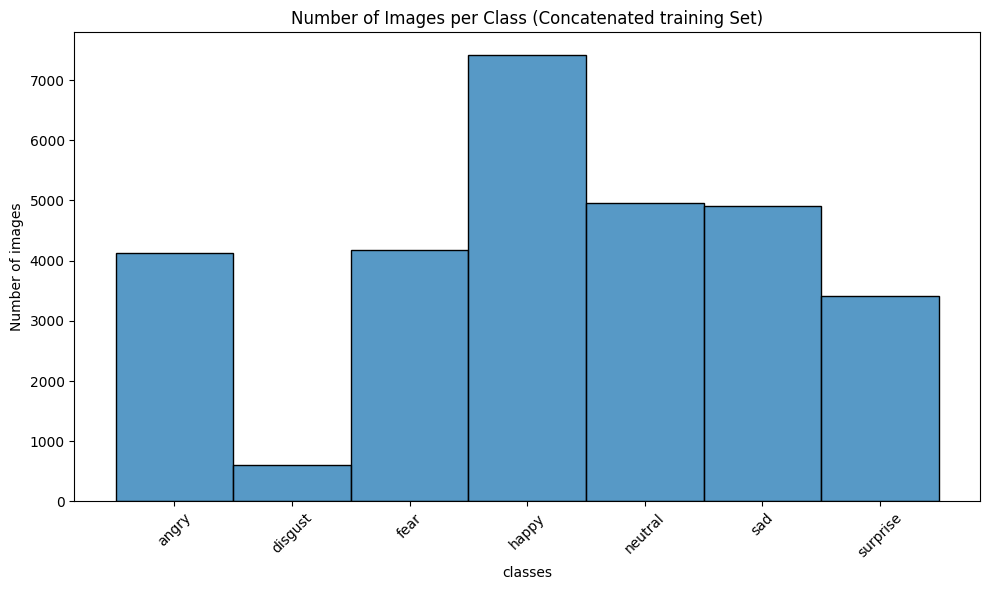

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(x=train_classes_concatenated, weights=train_num_images_concatenated, bins=len(train_classes_concatenated), kde=False)
plt.xticks(rotation=45)
plt.xlabel('classes')
plt.ylabel('Number of images')
plt.title('Number of Images per Class (Concatenated training Set)')
plt.tight_layout()
plt.show()

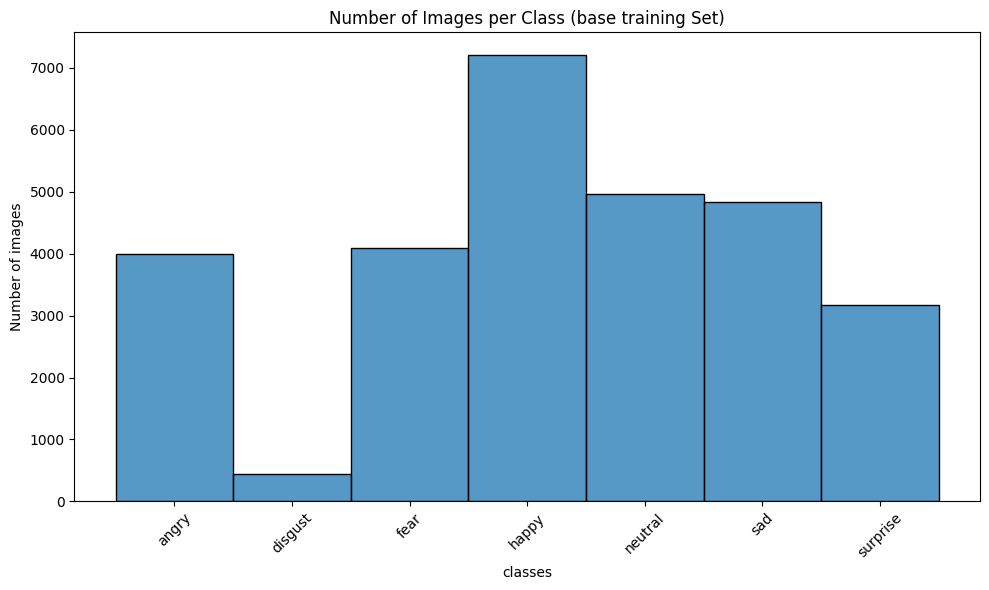

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(x=train_classes, weights=train_num_images, bins=len(train_classes), kde=False)
plt.xticks(rotation=45)
plt.xlabel('classes')
plt.ylabel('Number of images')
plt.title('Number of Images per Class (base training Set)')
plt.tight_layout()
plt.show()

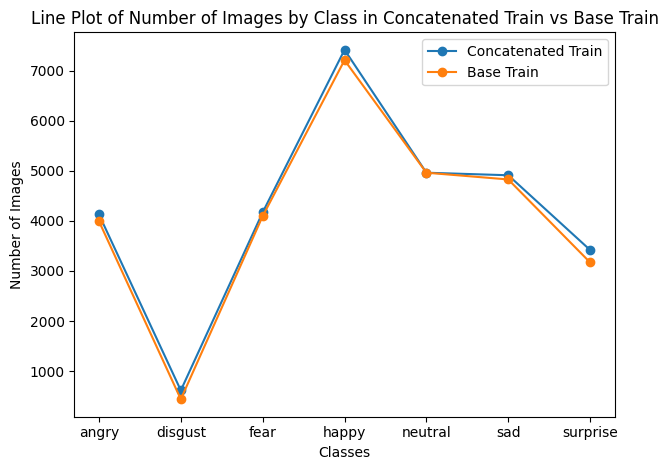

In [26]:
fig, ax = plt.subplots()
ax.plot(train_classes_concatenated, train_num_images_concatenated, label='Concatenated Train', marker='o')
ax.plot(train_classes, train_num_images, label='Base Train', marker='o')


ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Line Plot of Number of Images by Class in Concatenated Train vs Base Train')
ax.legend()

plt.xticks()
plt.tight_layout()
plt.show()

## Data augmentation and definition of importance by classes (balancing) in the train set

In [4]:
img_shape = 48

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_dir= 'concatenatedFERandCK'
test_dir = 'fer2013/test'

train_datagen = ImageDataGenerator(
    rescale=1/255,                
    rotation_range=10,            
    zoom_range=0.2,               
    width_shift_range=0.1,        
    height_shift_range=0.1,           
    horizontal_flip=True,         
    fill_mode='nearest',          
    validation_split=0.2          
)

val_datagen = ImageDataGenerator(
    rescale=1/255, 
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    subset="training",              
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_shape, img_shape),       
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    subset="validation",            
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_shape, img_shape),       
    color_mode='rgb',             
    class_mode='categorical',     
    batch_size=64,                 
    seed = 42,
    shuffle=False
)




classes = np.array(train_generator.classes)


class_weights = compute_class_weight(
    class_weight='balanced',  
    classes=np.unique(classes),  
    y=classes  
)


class_weights_dict = dict(enumerate(class_weights))

print("Class Weights Dictionary:", class_weights_dict)

Found 23711 images belonging to 7 classes.
Found 5925 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class Weights Dictionary: {0: 1.025207540643376, 1: 6.898748908932208, 2: 1.0147650432251991, 3: 0.570442188326998, 4: 0.8527909653287297, 5: 0.8614663566342101, 6: 1.2380430242272347}


## Model 1 66.55%

In [ ]:
model_MoreData = tf.keras.Sequential([

        tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',input_shape=(48,48,3)),
        tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu' ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(128,(5,5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=L2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(7, activation='softmax')
    ])

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate=1e-4)
model_MoreData.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_MoreData.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       2

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test1_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test1_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test1_MoreData/64batch', exist_ok=True)



log_dir = "logs/test1_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historytest1_MoreData = model_MoreData.fit(x = train_generator,epochs = 300,validation_data = val_generator, class_weight=class_weights_dict, callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
371/371 [==============================] - ETA: 0s - loss: 9.9715 - accuracy: 0.1624
Epoch 1: val_accuracy improved from -inf to 0.18160, saving model to models/test1_MoreData/64batch\best_model_ModelPaper2_1_0.1816.h5
371/371 [==============================] - 55s 122ms/step - loss: 9.9715 - accuracy: 0.1624 - val_loss: 9.4257 - val_accuracy: 0.1816 - lr: 1.0000e-04
Epoch 2/300
371/371 [==============================] - ETA: 0s - loss: 9.2236 - accuracy: 0.1752
Epoch 2: val_accuracy improved from 0.18160 to 0.19595, saving model to models/test1_MoreData/64batch\best_model_ModelPaper2_2_0.1959.h5
371/371 [==============================] - 45s 120ms/step - loss: 9.2236 - accuracy: 0.1752 - val_loss: 8.6765 - val_accuracy: 0.1959 - lr: 1.0000e-04
Epoch 3/300
371/371 [==============================] - ETA: 0s - loss: 8.5382 - accuracy: 0.1853
Epoch 3: val_accuracy improved from 0.19595 to 0.23882, saving model to models/test1_MoreData/64batch\best_model_ModelPaper2_3_0.2388.h5

In [ ]:
model_MoreData.evaluate(test_generator)

113/113 [==============================] - 25s 221ms/step - loss: 1.2571 - accuracy: 0.6655


[1.257135033607483, 0.6655057072639465]

In [ ]:
model_MoreData.save('models/test1_MoreData/64batch/best_model_ModelPaper2_122_0.6655.h5')

In [ ]:
model_MoreData_load = tf.keras.models.load_model(r'models\test1_MoreData\64batch\best_model_ModelPaper2_114_0.6675.h5')
model_MoreData_load.evaluate(test_generator)

113/113 [==============================] - 5s 41ms/step - loss: 1.2617 - accuracy: 0.6643


[1.2616521120071411, 0.6642518639564514]

In [8]:
model_MoreData_load = tf.keras.models.load_model(r'models/test1_MoreData/64batch/best_model_ModelPaper2_122_0.6655.h5')
model_MoreData_load.evaluate(test_generator)

113/113 [==============================] - 5s 42ms/step - loss: 1.2571 - accuracy: 0.6655


[1.257135033607483, 0.6655057072639465]

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model_MoreData_load.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 5s 38ms/step
              precision    recall  f1-score   support

           0       0.56      0.64      0.59       958
           1       0.60      0.76      0.67       111
           2       0.57      0.40      0.47      1024
           3       0.91      0.84      0.87      1774
           4       0.56      0.72      0.63      1233
           5       0.57      0.49      0.53      1247
           6       0.75      0.82      0.78       831

    accuracy                           0.67      7178
   macro avg       0.64      0.67      0.65      7178
weighted avg       0.67      0.67      0.66      7178

<function confusion_matrix at 0x000001D18BC96050>


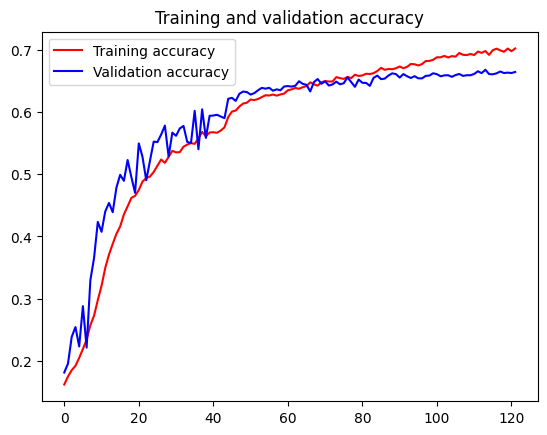

<Figure size 640x480 with 0 Axes>

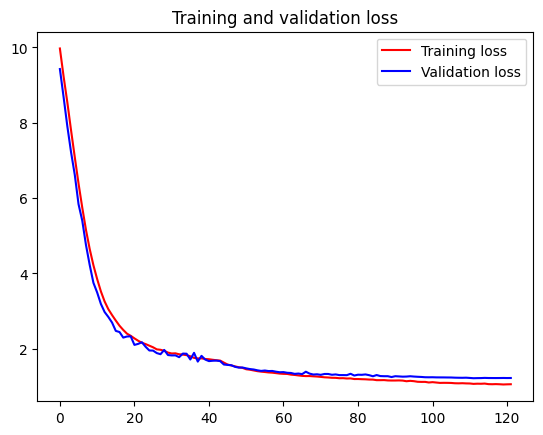

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest1_MoreData.history['accuracy']
val_acc = historytest1_MoreData.history['val_accuracy']
loss = historytest1_MoreData.history['loss']
val_loss = historytest1_MoreData.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 2 66.07%

In [4]:
model8_MoreData = tf.keras.models.Sequential()   

model8_MoreData.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,3)))
model8_MoreData.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model8_MoreData.add(BatchNormalization())
model8_MoreData.add(MaxPooling2D(2, 2))
model8_MoreData.add(Dropout(0.3))

model8_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData.add(BatchNormalization())
model8_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData.add(Dropout(0.3))

model8_MoreData.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model8_MoreData.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model8_MoreData.add(BatchNormalization())
model8_MoreData.add(MaxPooling2D(pool_size=(2, 2)))
model8_MoreData.add(Dropout(0.3))

model8_MoreData.add(Flatten())
model8_MoreData.add(Dense(1024, activation='relu',kernel_regularizer=L2(0.01)))
model8_MoreData.add(Dropout(0.5))
    
model8_MoreData.add(Dense(7, activation='softmax'))

model8_MoreData.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

model8_MoreData.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test8_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test8_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test8_MoreData/64batch', exist_ok=True)



log_dir = "logs/test8_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historytest8_MoreData = model8_MoreData.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
371/371 [==============================] - ETA: 0s - loss: 23.1789 - accuracy: 0.1733
Epoch 1: val_accuracy improved from -inf to 0.16776, saving model to models/test8_MoreData/64batch\best_model_ModelPaper2_1_0.1678.h5
371/371 [==============================] - 46s 119ms/step - loss: 23.1789 - accuracy: 0.1733 - val_loss: 21.6945 - val_accuracy: 0.1678 - lr: 1.0000e-04
Epoch 2/300
371/371 [==============================] - ETA: 0s - loss: 18.8375 - accuracy: 0.1986
Epoch 2: val_accuracy improved from 0.16776 to 0.27983, saving model to models/test8_MoreData/64batch\best_model_ModelPaper2_2_0.2798.h5
371/371 [==============================] - 44s 118ms/step - loss: 18.8375 - accuracy: 0.1986 - val_loss: 16.9249 - val_accuracy: 0.2798 - lr: 1.0000e-04
Epoch 3/300
371/371 [==============================] - ETA: 0s - loss: 14.9850 - accuracy: 0.2142
Epoch 3: val_accuracy improved from 0.27983 to 0.28759, saving model to models/test8_MoreData/64batch\best_model_ModelPaper2_3_0.

In [ ]:
model8_MoreData.evaluate(test_generator)

113/113 [==============================] - 25s 224ms/step - loss: 1.1465 - accuracy: 0.6655


[1.1464580297470093, 0.6655057072639465]

In [ ]:
model8_load = tf.keras.models.load_model(r'models/test8_MoreData/64batch\best_model_ModelPaper2_81_0.6739.h5')
model8_load.evaluate(test_generator)

113/113 [==============================] - 5s 42ms/step - loss: 1.1677 - accuracy: 0.6608


[1.1676567792892456, 0.6607690453529358]

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model8_load.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 5s 39ms/step
              precision    recall  f1-score   support

           0       0.56      0.61      0.59       958
           1       0.52      0.72      0.60       111
           2       0.52      0.41      0.46      1024
           3       0.90      0.84      0.87      1774
           4       0.58      0.71      0.64      1233
           5       0.56      0.48      0.52      1247
           6       0.73      0.84      0.78       831

    accuracy                           0.66      7178
   macro avg       0.63      0.66      0.64      7178
weighted avg       0.66      0.66      0.66      7178

<function confusion_matrix at 0x000001D18BC96050>


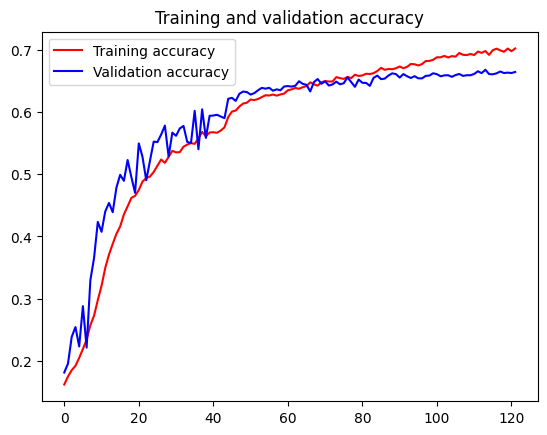

<Figure size 640x480 with 0 Axes>

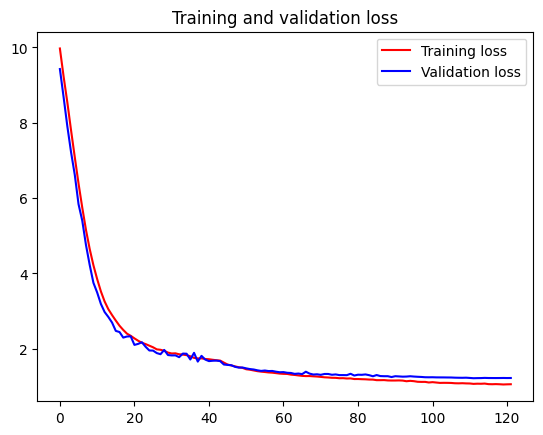

In [ ]:
import matplotlib.pyplot as plt
accuracy = historytest1_MoreData.history['accuracy']
val_acc = historytest1_MoreData.history['val_accuracy']
loss = historytest1_MoreData.history['loss']
val_loss = historytest1_MoreData.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

## Model 3 65.88%

In [5]:
model13 = tf.keras.models.Sequential()

model13.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 3)))
model13.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model13.add(BatchNormalization())
model13.add(MaxPooling2D(2, 2))
model13.add(Dropout(0.3))

model13.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model13.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model13.add(BatchNormalization())
model13.add(MaxPooling2D(pool_size=(2, 2)))
model13.add(Dropout(0.3))

model13.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=L2(0.01)))
model13.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=L2(0.01)))
model13.add(BatchNormalization())
model13.add(MaxPooling2D(pool_size=(2, 2)))
model13.add(Dropout(0.3))

model13.add(Flatten())
model13.add(Dense(2048, activation='relu', kernel_regularizer=L2(0.01)))
model13.add(Dropout(0.5))
model13.add(Dense(1024, activation='relu', kernel_regularizer=L2(0.01)))
model13.add(Dropout(0.5))

model13.add(Dense(7, activation='softmax'))

model13.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model13.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_3 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 128)      

In [ ]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/test13_MoreData/64batch', exist_ok=True)


checkpoint_path = 'models/test13_MoreData/64batch/best_model_ModelPaper2_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/test13_MoreData/64batch', exist_ok=True)



log_dir = "logs/test13_MoreData/64batch" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001,
                              min_lr=1e-6)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
historymodel_new13 = model13.fit(
    x = train_generator,
    epochs = 300,
    validation_data = val_generator, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping,model_checkpoint, tensorboard_callback,reduce_lr], shuffle=True)

Epoch 1/300
371/371 [==============================] - ETA: 0s - loss: 44.8097 - accuracy: 0.1697
Epoch 1: val_accuracy improved from -inf to 0.16759, saving model to models/test13_MoreData/64batch\best_model_ModelPaper2_1_0.1676.h5
371/371 [==============================] - 47s 124ms/step - loss: 44.8097 - accuracy: 0.1697 - val_loss: 39.3375 - val_accuracy: 0.1676 - lr: 1.0000e-04
Epoch 2/300
371/371 [==============================] - ETA: 0s - loss: 34.0022 - accuracy: 0.1838
Epoch 2: val_accuracy improved from 0.16759 to 0.26278, saving model to models/test13_MoreData/64batch\best_model_ModelPaper2_2_0.2628.h5
371/371 [==============================] - 45s 121ms/step - loss: 34.0022 - accuracy: 0.1838 - val_loss: 28.9388 - val_accuracy: 0.2628 - lr: 1.0000e-04
Epoch 3/300
371/371 [==============================] - ETA: 0s - loss: 24.8431 - accuracy: 0.2016
Epoch 3: val_accuracy did not improve from 0.26278
371/371 [==============================] - 44s 120ms/step - loss: 24.8431 - 

In [ ]:
model13.evaluate(test_generator)

113/113 [==============================] - 10s 91ms/step - loss: 1.1481 - accuracy: 0.6588


[1.1480631828308105, 0.6588186025619507]

In [ ]:
model13_load = tf.keras.models.load_model(r'models/test13_MoreData/64batch\best_model_ModelPaper2_113_0.6743.h5')
model13_load.evaluate(test_generator)

113/113 [==============================] - 6s 53ms/step - loss: 1.1481 - accuracy: 0.6588


[1.1480631828308105, 0.6588186025619507]

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes #Obtener todas las clases de y_test
y_pred = model13_load.predict(test_generator).argmax(axis=1) #El mejor

report = classification_report(y_true, y_pred)
print(report)

matrix = confusion_matrix(y_true, y_pred)
print(confusion_matrix)

113/113 [==============================] - 4s 37ms/step
              precision    recall  f1-score   support

           0       0.56      0.62      0.59       958
           1       0.56      0.72      0.63       111
           2       0.53      0.39      0.45      1024
           3       0.89      0.85      0.87      1774
           4       0.57      0.71      0.63      1233
           5       0.56      0.49      0.52      1247
           6       0.74      0.80      0.77       831

    accuracy                           0.66      7178
   macro avg       0.63      0.65      0.64      7178
weighted avg       0.66      0.66      0.66      7178

<function confusion_matrix at 0x000001D18BC96050>


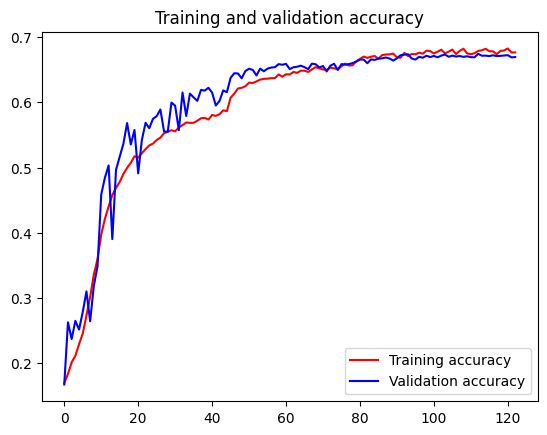

<Figure size 640x480 with 0 Axes>

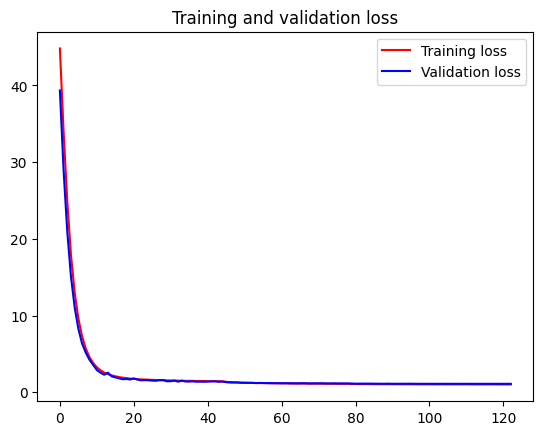

In [ ]:
import matplotlib.pyplot as plt
accuracy = historymodel_new13.history['accuracy']
val_acc = historymodel_new13.history['val_accuracy']
loss = historymodel_new13.history['loss']
val_loss = historymodel_new13.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()